↓参考にしたページ↓

https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda

https://www.kaggle.com/plasticgrammer/ieee-cis-fraud-detection-playground

# 前準備

インストール

In [1]:
!pip install --upgrade pip
!pip install pandas-profiling
!pip install catboost
!pip install lightgbm

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.2.3)
     |████████████████████████████████| 62.5MB 1.2MB/s 


ライブラリのインポート

In [0]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import pandas_profiling as pdp
import seaborn as sns
import gc
import lightgbm as lgb
import altair as alt
%matplotlib inline

plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

# データ読み込み＆外観を眺める

Googleドライブへのアクセス権限付与

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


データ読み込み

In [0]:
#パスを設定してデータ読み込み
train_transaction = pd.read_csv("./drive/My Drive/train_transaction.csv")
test_transaction = pd.read_csv("./drive/My Drive/test_transaction.csv")
train_identity = pd.read_csv("./drive/My Drive/train_identity.csv")
test_identity = pd.read_csv("./drive/My Drive/test_identity.csv")

#TransactionIDをキーに結合
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

データサイズ

In [0]:
print(f'Train dataset :  {train.shape[0]} 列 × {train.shape[1]} カラム.')
print(f'Test dataset : {test.shape[0]}  列 × {test.shape[1]} カラム.')

Train dataset :  590540 列 × 434 カラム.
Test dataset : 506691  列 × 433 カラム.


データセットの大きさは普通くらい，カラムが多いデータセットらしい

データをざっと見てみる

In [0]:
#デフォルトで表示されるカラムが少ないので，全部表示できるようにする．
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [0]:
train_transaction.head(10)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   
5  555.0  150.0        visa  226.0   debit  272.0   87.0   36.0    NaN   
6  360.0  150.0        visa  166.0   debit  126.0   87.0    0.0    NaN   
7  490.0  150.0        visa  226.0   debit  325.0   87.0    NaN    NaN   
8  100.0  150.0        visa  226.0   debit  337.0   87.0    NaN    NaN   
9  111.0  150.0  mastercard  224.0   debit  204.0   87.0   19.0    NaN   

   P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0            NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1      gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2    outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3      yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4      gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
5      gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
6      yahoo.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
7       mail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
8  anonymous.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
9      yahoo.com           NaN  2.0  2.0  0.0  0.0  0.0  3.0  0.0  0.0  3.0   

   C10  C11  C12   C13  C14     D1     D2    D3     D4    D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0    NaN   NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0   94.0   0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    NaN   NaN NaN NaN NaN NaN   
5  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
6  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
7  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
8  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    NaN   NaN NaN NaN NaN NaN   
9  0.0  1.0  0.0  12.0  2.0   61.0   61.0  30.0  318.0  30.0 NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5   0.0    0.0  NaN  NaN  NaN    0.0    T    T    T   M1    F    T  NaN  NaN   
6   0.0    0.0  NaN  NaN  NaN

In [0]:
test_transaction.head(10)

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   
2        3663551       18403310          171.00         W   4476  574.0   
3        3663552       18403310          284.95         W  10989  360.0   
4        3663553       18403317           67.95         W  18018  452.0   
5        3663554       18403323           57.95         W  12839  321.0   
6        3663555       18403350           87.00         W  16560  476.0   
7        3663556       18403387          390.00         W  15066  170.0   
8        3663557       18403405          103.95         W   2803  100.0   
9        3663558       18403416          117.00         W  12544  321.0   

   card3       card4  card5   card6  addr1  addr2   dist1  dist2  \
0  150.0        visa  226.0   debit  170.0   87.0     1.0    NaN   
1  150.0        visa  226.0   debit  299.0   87.0     4.0    NaN   
2  150.0        visa  226.0   debit  472.0   87.0  2635.0    NaN   
3  150.0        visa  166.0   debit  205.0   87.0    17.0    NaN   
4  150.0  mastercard  117.0   debit  264.0   87.0     6.0    NaN   
5  150.0        visa  226.0   debit  512.0   87.0     NaN    NaN   
6  150.0        visa  126.0   debit  110.0   87.0     NaN    NaN   
7  150.0  mastercard  102.0  credit  194.0   87.0   303.0    NaN   
8  150.0        visa  226.0   debit  494.0   87.0     3.0    NaN   
9  150.0        visa  226.0   debit  476.0   87.0     8.0    NaN   

  P_emaildomain R_emaildomain     C1     C2   C3   C4     C5    C6   C7   C8  \
0     gmail.com           NaN    6.0    6.0  0.0  0.0    3.0   4.0  0.0  0.0   
1       aol.com           NaN    3.0    2.0  0.0  0.0    0.0   1.0  0.0  0.0   
2   hotmail.com           NaN    2.0    2.0  0.0  0.0    0.0   5.0  0.0  0.0   
3     gmail.com           NaN    5.0    2.0  0.0  0.0    1.0   1.0  0.0  0.0   
4     gmail.com           NaN    6.0    6.0  0.0  0.0    2.0   5.0  0.0  0.0   
5     gmail.com           NaN    5.0    5.0  0.0  0.0    2.0   3.0  0.0  0.0   
6     gmail.com           NaN    1.0    1.0  0.0  0.0    0.0   1.0  0.0  0.0   
7     gmail.com           NaN    3.0    1.0  0.0  0.0    0.0   1.0  0.0  0.0   
8     gmail.com           NaN  152.0  148.0  0.0  0.0  135.0  95.0  0.0  0.0   
9           NaN           NaN    2.0    2.0  0.0  0.0    0.0   1.0  0.0  0.0   

     C9  C10    C11  C12    C13    C14     D1     D2    D3     D4    D5  D6  \
0   6.0  0.0    5.0  1.0  115.0    6.0  419.0  419.0  27.0  398.0  27.0 NaN   
1   2.0  0.0    1.0  1.0   12.0    2.0  149.0  149.0   7.0  634.0   7.0 NaN   
2   4.0  0.0    2.0  0.0   22.0    2.0  137.0  137.0  10.0   97.0  10.0 NaN   
3   2.0  0.0    2.0  0.0    7.0    4.0   42.0   42.0  41.0  242.0  41.0 NaN   
4   5.0  0.0    6.0  0.0   14.0    6.0   22.0   22.0   0.0   22.0   0.0 NaN   
5   2.0  0.0    4.0  0.0   10.0    4.0   36.0   36.0  35.0    0.0   NaN NaN   
6   1.0  0.0    1.0  0.0    2.0    1.0    NaN    NaN   0.0    0.0   NaN NaN   
7   3.0  0.0    1.0  1.0   11.0    1.0    NaN    NaN   NaN  126.0   4.0 NaN   
8  77.0  0.0  122.0  0.0  407.0  108.0  128.0  128.0  13.0  644.0  13.0 NaN   
9   2.0  0.0    2.0  1.0    8.0    2.0   69.0   69.0  35.0    NaN   NaN NaN   

   D7  D8  D9    D10    D11  D12  D13  D14    D15 M1 M2 M3   M4   M5 M6   M7  \
0 NaN NaN NaN  418.0  203.0  NaN  NaN  NaN  409.0  T  T  F  NaN  NaN  F    T   
1 NaN NaN NaN  231.0  634.0  NaN  NaN  NaN  634.0  T  F  F   M0  NaN  F  NaN   
2 NaN NaN NaN  136.0  136.0  NaN  NaN  NaN   97.0  T  T  F   M0    F  F    F   
3 NaN NaN NaN  242.0  242.0  NaN  NaN  NaN  242.0  T  T  T  NaN  NaN  T  NaN   
4 NaN NaN NaN   22.0   22.0  NaN  NaN  NaN   22.0  T  T  T  NaN  NaN  F    F   
5 NaN NaN NaN    0.0    0.0  NaN  NaN  NaN    0.0  T  T  T  NaN  NaN  T    F   
6 NaN NaN NaN    0.0    0.0  NaN  NaN  NaN    0.0  T  T  T   M1    T  F    T   
7 NaN NaN NaN  126.0  126.0  NaN  NaN

In [0]:
train_identity.head(10)

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   
5        2987017   -5.0   61141.0    3.0    0.0    3.0    0.0    NaN    NaN   
6        2987022  -15.0       NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7        2987038    0.0   31964.0    0.0    0.0    0.0  -10.0    NaN    NaN   
8        2987040  -10.0  116098.0    0.0    0.0    0.0    0.0    NaN    NaN   
9        2987048   -5.0  257037.0    NaN    NaN    0.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN   
1    NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN   
2    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   
3    NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN   
4    0.0    0.0  100.0  NotFound    NaN -300.0  Found     Found  166.0   15.0   
5    3.0    0.0  100.0  NotFound   52.0 -300.0  Found     Found  166.0   18.0   
6    NaN    NaN    NaN  NotFound   14.0    NaN    NaN       NaN    NaN    NaN   
7    0.0    0.0  100.0     Found    NaN -300.0  Found     Found  166.0   15.0   
8    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   
9    NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  542.0  144.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  621.0  500.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
2  410.0  142.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
3  176.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
4  529.0  575.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
5  529.0  600.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
6    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   NaN    NaN   
7  352.0  533.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
8  410.0  142.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
9  484.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   

      id_29             id_30                id_31  id_32      id_33  \
0  NotFound       Android 7.0  samsung browser 6.2   32.0  2220x1080   
1  NotFound        iOS 11.1.2   mobile safari 11.0   32.0   1334x750   
2     Found               NaN          chrome 62.0    NaN        NaN   
3  NotFound               NaN          chrome 62.0    NaN        NaN   
4     Found  Mac OS X 10_11_6          chrome 62.0   24.0   1280x800   
5     Found        Windows 10          chrome 62.0   24.0   1366x768   
6       NaN               NaN                  NaN    NaN        NaN   
7     Found           Android          chrome 62.0   32.0  1920x1080   
8     Found               NaN          chrome 62.0    NaN        NaN   
9  NotFound               NaN          chrome 62.0    NaN        NaN   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   
2             NaN     F     F     T     T    desktop   
3             NaN     F     F     T     T    desktop   
4  match_status:2     T     F     T     T    desktop   
5  match_status:2     T     F     T     T    desktop   
6             NaN   NaN   NaN   NaN   NaN        NaN   
7  match_status:2     T     F     T     T     mobile   
8             NaN     F     F     T     T    desktop   
9             NaN     F     F     T     T    desktop   

                      Devic

In [0]:
test_identity.head(10)

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        3663586  -45.0  280290.0    NaN    NaN    0.0    0.0    NaN    NaN   
1        3663588    0.0    3579.0    0.0    0.0    0.0    0.0    NaN    NaN   
2        3663597   -5.0  185210.0    NaN    NaN    1.0    0.0    NaN    NaN   
3        3663601  -45.0  252944.0    0.0    0.0    0.0    0.0    NaN    NaN   
4        3663602  -95.0  328680.0    NaN    NaN    7.0  -33.0    NaN    NaN   
5        3663622   -5.0   36786.0    NaN    NaN    4.0   -2.0    NaN    NaN   
6        3663624   -5.0   12577.0    0.0    0.0    2.0   -2.0    NaN    NaN   
7        3663626   -5.0   44726.0    0.0    0.0    0.0   -2.0    NaN    NaN   
8        3663629   -5.0  125997.0    0.0    0.0    2.0   -2.0    NaN    NaN   
9        3663658   -5.0   98741.0    NaN    NaN    0.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0   
1    0.0    0.0  100.0     Found    NaN -300.0  Found     Found  166.0    NaN   
2    NaN    NaN  100.0  NotFound   52.0 -360.0    New  NotFound  225.0    NaN   
3    0.0    0.0  100.0  NotFound   27.0    NaN  Found     Found  225.0   15.0   
4    NaN    NaN  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0   
5    NaN    NaN  100.0  NotFound   27.0 -480.0    New  NotFound  166.0   15.0   
6    0.0    0.0  100.0     Found   27.0 -480.0  Found     Found  166.0   15.0   
7    0.0    0.0  100.0     Found   27.0 -480.0  Found     Found  166.0   15.0   
8    0.0    0.0  100.0     Found   27.0 -480.0  Found     Found  166.0   15.0   
9    NaN    NaN  100.0     Found   27.0 -360.0    New  NotFound  166.0    NaN   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  427.0  563.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  542.0  368.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
2  271.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
3  427.0  563.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
4  567.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
5  352.0  177.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
6  352.0  177.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
7  352.0  177.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
8  352.0  177.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
9  529.0  214.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   

      id_29          id_30                    id_31  id_32      id_33  \
0  NotFound            NaN  chrome 67.0 for android    NaN        NaN   
1     Found  Android 6.0.1  chrome 67.0 for android   24.0   1280x720   
2  NotFound            NaN       ie 11.0 for tablet    NaN        NaN   
3     Found            NaN  chrome 67.0 for android    NaN        NaN   
4  NotFound            NaN  chrome 67.0 for android    NaN        NaN   
5  NotFound     iOS 11.4.0       mobile safari 11.0   32.0  2208x1242   
6     Found     iOS 11.4.0       mobile safari 11.0   32.0  2208x1242   
7     Found     iOS 11.4.0       mobile safari 11.0   32.0  2208x1242   
8     Found     iOS 11.4.0       mobile safari 11.0   32.0  2208x1242   
9  NotFound     iOS 11.4.0       mobile safari 11.0   32.0  2048x1536   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0             NaN     F     F     T     F     mobile   
1  match_status:2     T     F     T     T     mobile   
2             NaN     F     T     T     F    desktop   
3             NaN     F     F     T     F     mobile   
4             NaN     F     F     T     F     mobile   
5  match_status:2     T     F     F     T     mobile   
6  match_status:2     T     F     F     T     mobile   
7  match_status:2     T     F     F     T     mobile   
8  match_status:2     T     F     F     T     mobile   
9  match_status:2     T     F     F     F     mobile   

                

In [0]:
print(f' {train.isnull().any().sum()} のカラムに欠損データが含まれている')

 414 のカラムに欠損データが含まれている


In [0]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

False

In [0]:
print(f'Train datasetには，一つの値しか存在しないカラムが {len(one_value_cols)} 個存在する．')
print(f'Test datasetには，一つの値しか存在しないカラムが {len(one_value_cols_test)} 個存在する．')

Train datasetには，一つの値しか存在しないカラムが 0 個存在する．
Test datasetには，一つの値しか存在しないカラムが 1 個存在する．


In [0]:
print(np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique())))
print(np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique())))

144233
141907


train_transaction のうち，24.4%がTransactionIDs (144233 / 590540) でtrain_identityと関連づけられている．

test_transaction のうち，28.0% of TransactionIDs in test(141907 / 506691)でtest_identityと関連づけられている．

まとめ：欠損データがたくさん(現実のデータはこんなもん)

ほとんどが連続値を持ったカラムか，カテゴリー変数になっている

# TraindataとTestDataの関係

TransactionDTは，実際の時間ではなく，ある時点からの経過時間である．

TrainDataとTestDataは，経過時間で分けられている．TrainDataが前半に計測されたデータ，TestDataが後半に計測されたデータである．交差検証の際に重要となるらしい．

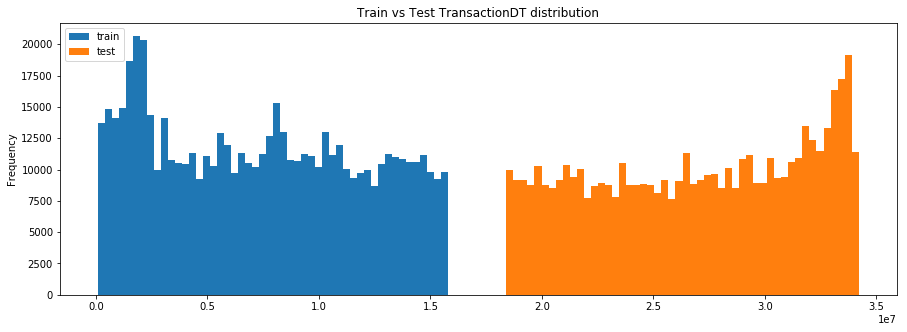

In [0]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

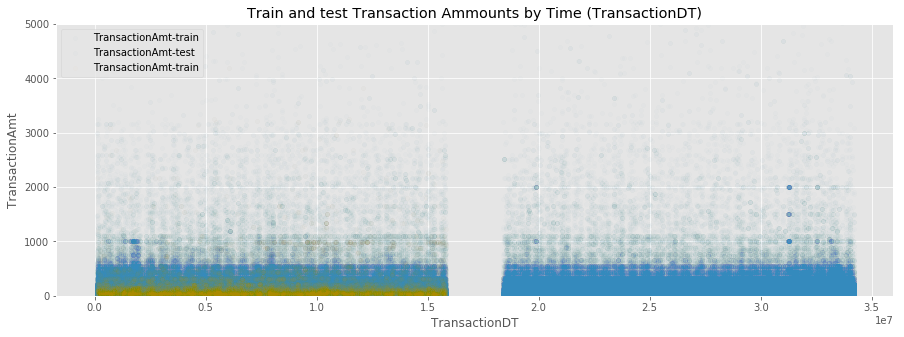

In [0]:
ax = train_transaction.plot(x='TransactionDT',
                       y='TransactionAmt',
                       kind='scatter',
                       alpha=0.01,
                       label='TransactionAmt-train',
                       title='Train and test Transaction Ammounts by Time (TransactionDT)',
                       ylim=(0, 5000),
                       figsize=(15, 5))
test_transaction.plot(x='TransactionDT',
                      y='TransactionAmt',
                      kind='scatter',
                      label='TransactionAmt-test',
                      alpha=0.01,
                      color=color_pal[1],
                       ylim=(0, 5000),
                      ax=ax)
# Plot Fraud as Orange
train_transaction.loc[train_transaction['isFraud'] == 1] \
    .plot(x='TransactionDT',
         y='TransactionAmt',
         kind='scatter',
         alpha=0.01,
         label='TransactionAmt-train',
         title='Train and test Transaction Ammounts by Time (TransactionDT)',
         ylim=(0, 5000),
         color='orange',
         figsize=(15, 5),
         ax=ax)
plt.show()


# データの分布

## Transaction Data

### isFraud

In [0]:
print(' TrainDataのうち　{:.4f}% がFraudである '.format(train['isFraud'].mean() * 100))

 TrainDataのうち　3.4990% がFraudである 


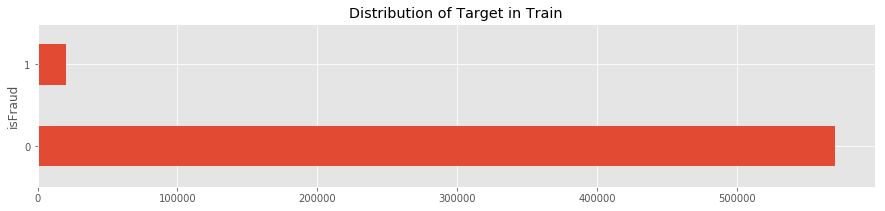

In [0]:
train_transaction.groupby('isFraud') \
    .count()['TransactionID'] \
    .plot(kind='barh',
          title='Distribution of Target in Train',
          figsize=(15, 3))
plt.show()

### TransactionAmt

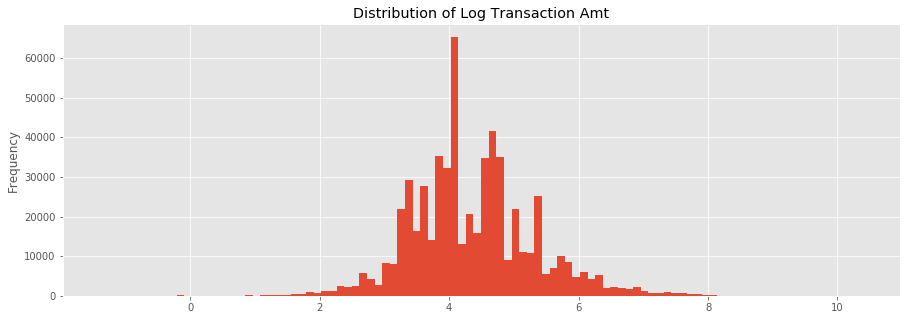

In [0]:
train_transaction['TransactionAmt'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt')
plt.show()

TransactionAmt(取引金額)の分布を上に示している，分布をいい感じに見せるために対数処理を行なっている．極端に小さいデータや大きいデータが分布を歪めてしまうためである．対数処理のため，0-1のデータは負の値を示している．

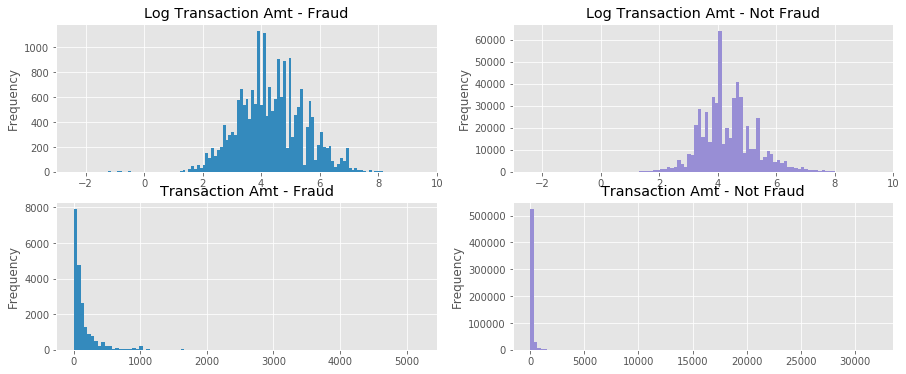

In [0]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train_transaction.loc[train_transaction['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color=color_pal[1],
          xlim=(-3, 10),
         ax= ax1)
train_transaction.loc[train_transaction['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color=color_pal[2],
          xlim=(-3, 10),
         ax=ax2)
train_transaction.loc[train_transaction['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color=color_pal[1],
         ax= ax3)
train_transaction.loc[train_transaction['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color=color_pal[2],
         ax=ax4)
plt.show()

Transaction Amtの対数とFraudの多さの分布をグラフにしている．右がFraudではない方の分布．下は対数処理しないとこんなに見にくいよ的なやつ．

ぱっと見，めちゃめちゃ大きい違いはなさそうだけど，ややFraudの方がTransactionAmtが多い傾向にありそう．

In [0]:
print('Fraudの平均取引金額： {:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].mean()))
print('non-Fraudの平均取引金額：{:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].mean()))

Fraudの平均取引金額： 149.2448
non-Fraudの平均取引金額：134.5117


実際，平均はFraudの方が高い．詐欺は大きな金額じゃないとあんまり意味ないから，直感的にも納得．

### ProductCD

ProductCDがなんなのかはよくわかんない．

数はWが一番多い．Cが一番少ない．

詐欺率が一番高いのがCで11%．一番低いのがWで2%．

一番少ないCでもっとも詐欺が行われている．

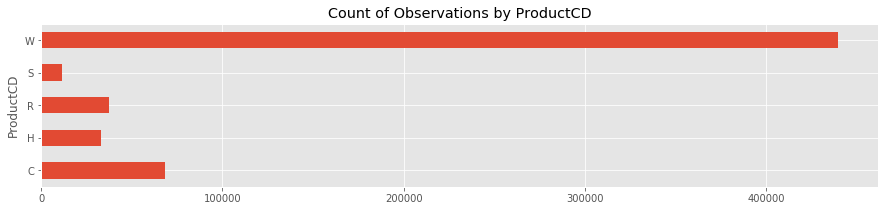

In [0]:
train_transaction.groupby('ProductCD') \
    ['TransactionID'].count() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Count of Observations by ProductCD')
plt.show()

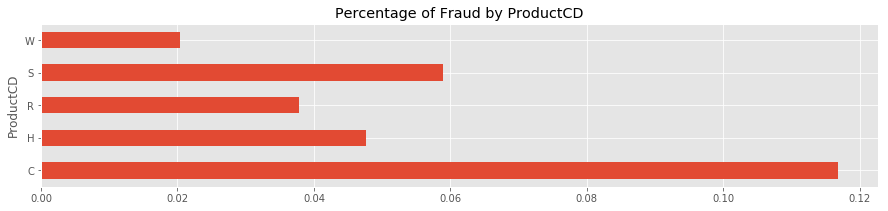

In [0]:
train_transaction.groupby('ProductCD')['isFraud'] \
    .mean() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Percentage of Fraud by ProductCD')
plt.show()

### TransationDT

TransactionDTをそれぞれの時間・日付がわかるように処理するといい特徴量になるっぽい．

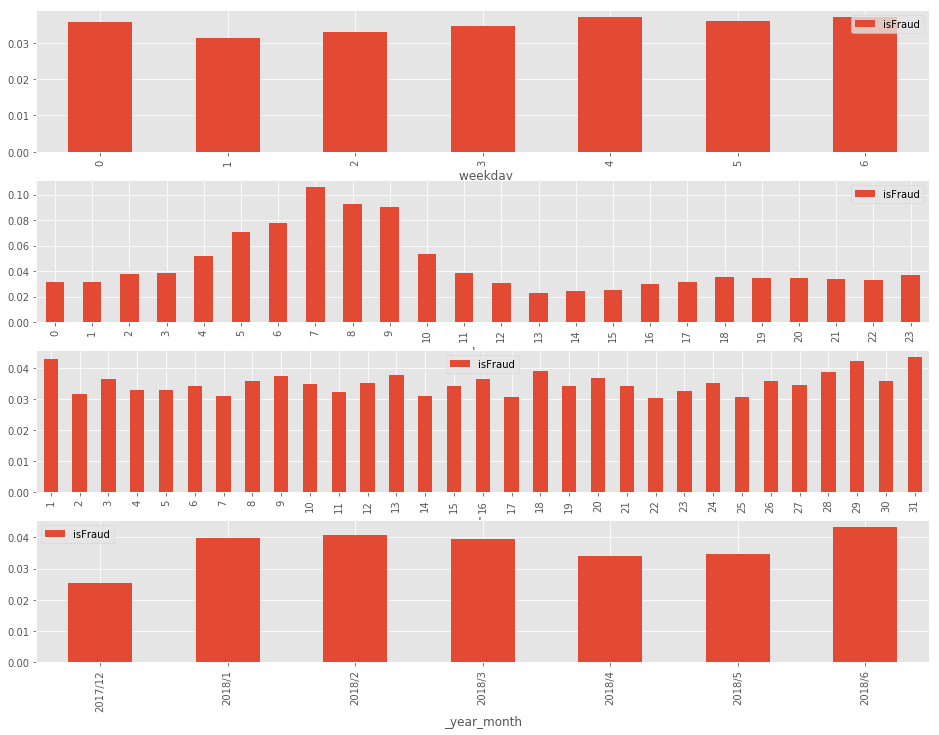

In [0]:
import datetime
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train_transaction['Date'] = train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train_transaction['_year_month'] = train_transaction['Date'].dt.year.astype(str) + '/' + train_transaction['Date'].dt.month.astype(str)
train_transaction['_weekday'] = train_transaction['Date'].dt.dayofweek
train_transaction['_hour'] = train_transaction['Date'].dt.hour
train_transaction['_day'] = train_transaction['Date'].dt.day

fig,ax = plt.subplots(4, 1, figsize=(16,12))

train_transaction.groupby('_weekday')['isFraud'].mean().to_frame().plot.bar(ax=ax[0])
train_transaction.groupby('_hour')['isFraud'].mean().to_frame().plot.bar(ax=ax[1])
train_transaction.groupby('_day')['isFraud'].mean().to_frame().plot.bar(ax=ax[2])
train_transaction.groupby('_year_month')['isFraud'].mean().to_frame().plot.bar(ax=ax[3])

上から

・一週間でどの日が多いか

あんま変わんないっぽいけど，多少の違いあり

・１日でどの時間帯が多いか(１時間ごと)

これエグい．明らかに7時ごろが多い．

・月でどの日が多いか

バラバラだけど，強いて言えば月末の方が多いかな？

・どの月が多いか

2017/12が極端に少ない．結構月ごとにFraud率変わるけど傾向はなさそう．たまたま？


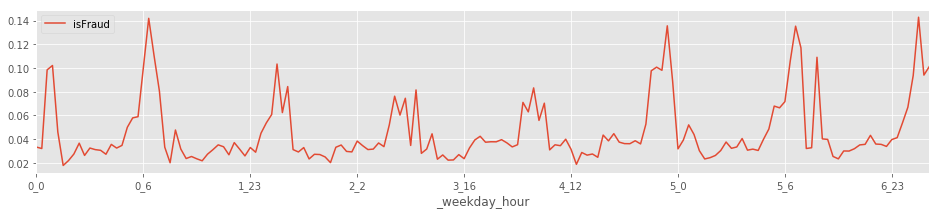

In [0]:
train_transaction['_weekday_hour'] = train_transaction['_weekday'].astype(str) + '_' + train_transaction['_hour'].astype(str)
train_transaction.groupby('_weekday_hour')['isFraud'].mean().to_frame().plot.line(figsize=(16,3))

こう見ると一週間の中でも偏りある．朝7時くらいがピークなのは共通だけど，明らかに少ない日(1,2,3の日)がある．

In [0]:
df = train_transaction.groupby('_weekday')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False)

isFraud
_weekday          
4         0.037174
6         0.037115
5         0.036040
0         0.035644
3         0.034514
2         0.033048
1         0.031452

週の後半に多い？

In [0]:
df = train_transaction.groupby('_hour')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False).head(10)

isFraud
_hour          
7      0.106102
8      0.093014
9      0.089956
6      0.077743
5      0.070302
10     0.053212
4      0.051890
11     0.038816
3      0.038314
2      0.037483

7時が一番多いという図

In [0]:
df = train_transaction.groupby('_weekday_hour')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False).head(10)

isFraud
_weekday_hour          
6_7            0.142857
0_7            0.141935
4_8            0.135593
5_8            0.135307
5_9            0.116998
0_8            0.110368
6_10           0.109034
5_7            0.105903
1_7            0.103327
0_11           0.102079

In [0]:
train_transaction['_amount_qcut10'] = pd.qcut(train_transaction['TransactionAmt'],10)
df = train_transaction.groupby('_amount_qcut10')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False)


isFraud
_amount_qcut10                
(0.25, 25.95]         0.055889
(275.293, 31937.391]  0.050870
(117.0, 159.95]       0.043026
(159.95, 275.293]     0.038037
(68.769, 100.0]       0.036170
(35.95, 49.0]         0.032250
(25.95, 35.95]        0.032052
(57.95, 68.769]       0.028513
(100.0, 117.0]        0.019742
(49.0, 57.95]         0.019431

### Categorical　Features

Data Descriptionで，以下のカラムはカテゴリー特徴量だと説明されている．

・ProductCD

・emaildomain

・card1 - card6

・addr1, addr2

・P_emaildomain

・R_emaildomain

・M1 - M9

### card1-card6

カテゴリーだよって言われてたのに数値が多いという謎．

card4はクレジットカードの決済システムの会社を示している．

card6はクレジットorデビットを示している．

ちなみに：クレジットカードは特定の口座から後日引き落とされる後払い制

デビットカードは特定の銀行口座から支払直後にお金を引き落とす．

card1,2,3,5はよくわからん．

In [0]:
card_cols = [c for c in train_transaction.columns if 'card' in c]
train_transaction[card_cols].head()

card1  card2  card3       card4  card5   card6
0  13926    NaN  150.0    discover  142.0  credit
1   2755  404.0  150.0  mastercard  102.0  credit
2   4663  490.0  150.0        visa  166.0   debit
3  18132  567.0  150.0  mastercard  117.0   debit
4   4497  514.0  150.0  mastercard  102.0  credit

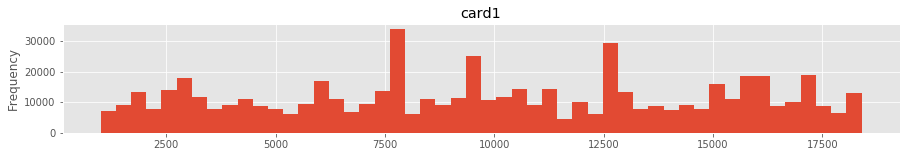

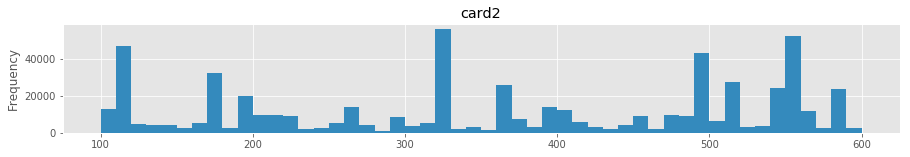

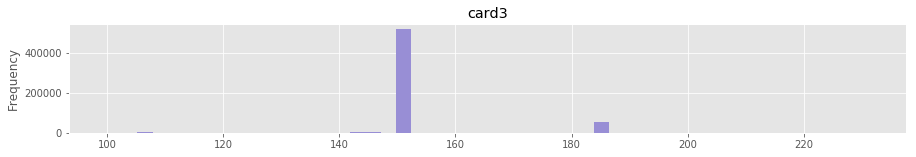

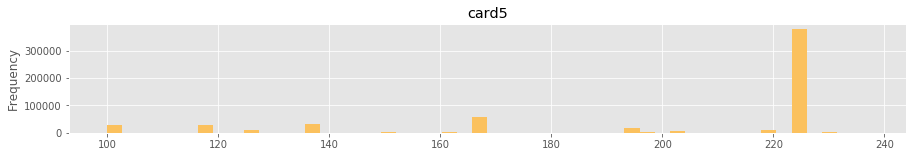

In [0]:
color_idx = 0
for c in card_cols:
    if train_transaction[c].dtype in ['float64','int64']:
        train_transaction[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

card1,2,3,5は数値なので，その分布をグラフ化．

card1,2はかなりばらついている．card3はほとんどが150．card5は225あたりにかなり集中しているが，他にも小さく集中しているポイントがいくつか存在する．

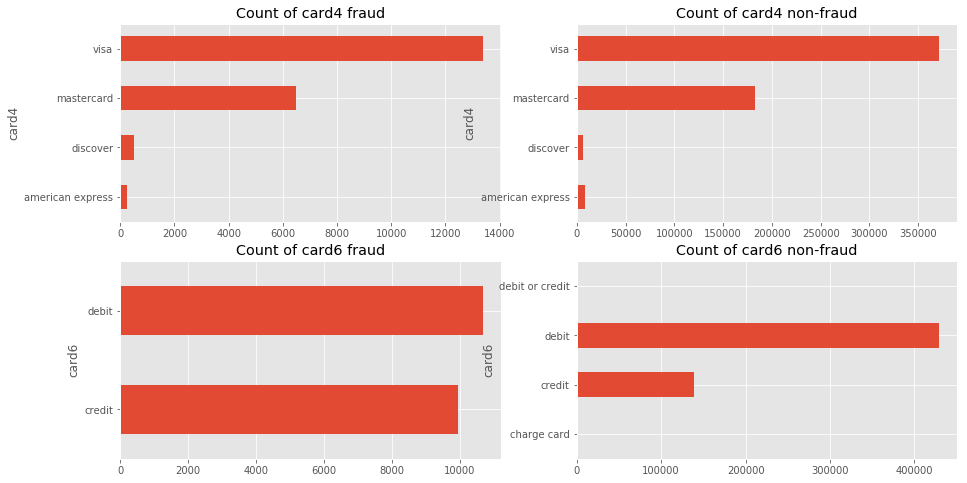

In [0]:
train_transaction_fr = train_transaction.loc[train_transaction['isFraud'] == 1]
train_transaction_nofr = train_transaction.loc[train_transaction['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_transaction_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_transaction_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_transaction_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_transaction_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')
plt.show()

card4,6のFraud,non-Fraudの分布の違いをグラフ化．

card4の方は，discoverがやや詐欺率高い？

card6の方は，明らかにcreditの詐欺率が高い．

### addr1 & addr2

これもカテゴリーって話だったけどどう見ても数値．

In [0]:
print(' addr1 - has {} NA values'.format(train_transaction['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train_transaction['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


欠損値は共に65706個存在．

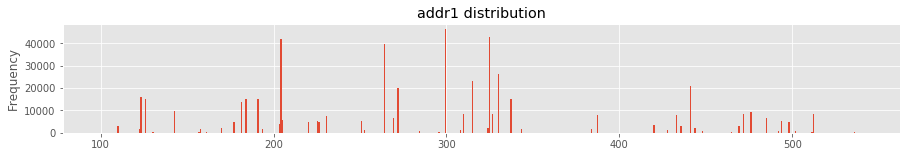

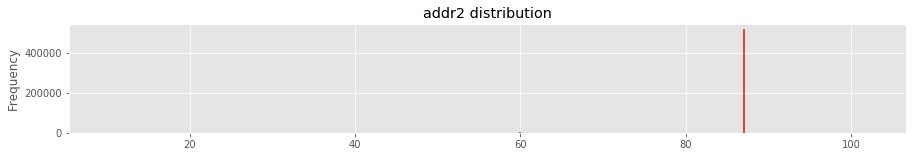

In [0]:
train_transaction['addr1'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr1 distribution')
plt.show()
train_transaction['addr2'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr2 distribution')
plt.show()

addr1はバラつき多い．何かしらの方法で住所を示しているとは思う．

addr2はほぼ87．謎．

### dist1 & dist2

これも見やすくするために対数変換してる．

取引した場所から家もしくは勤務先からの距離じゃないかと推測されてたけど，あってるかも．addr1が家からの距離で，0が一番近い．addr2が勤務先からの距離で，家の近くで取引することが多いのである程度の距離でもう一度ピークが訪れる．

そう考えるとaddr1，addr2とリンクしている気がするけど，addr2の値がほとんど87なのはおかしい．

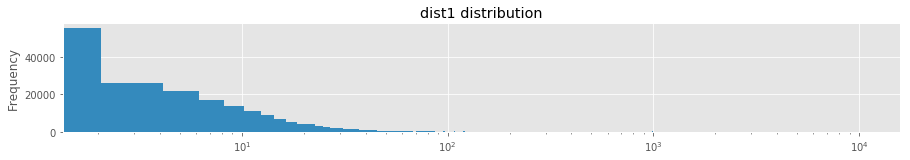

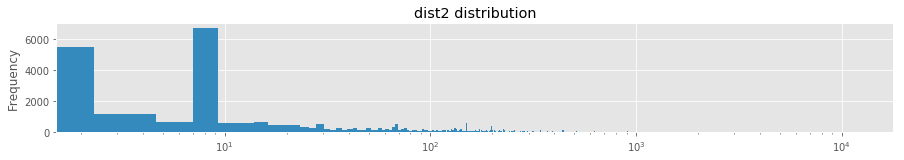

In [0]:
train_transaction['dist1'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist1 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()
train_transaction['dist2'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist2 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()

### C1-C14

In [0]:
c_cols = [c for c in train_transaction if c[0] == 'C']
train_transaction[c_cols].head()

C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14
0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0
1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0
2  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
3  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0
4  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0

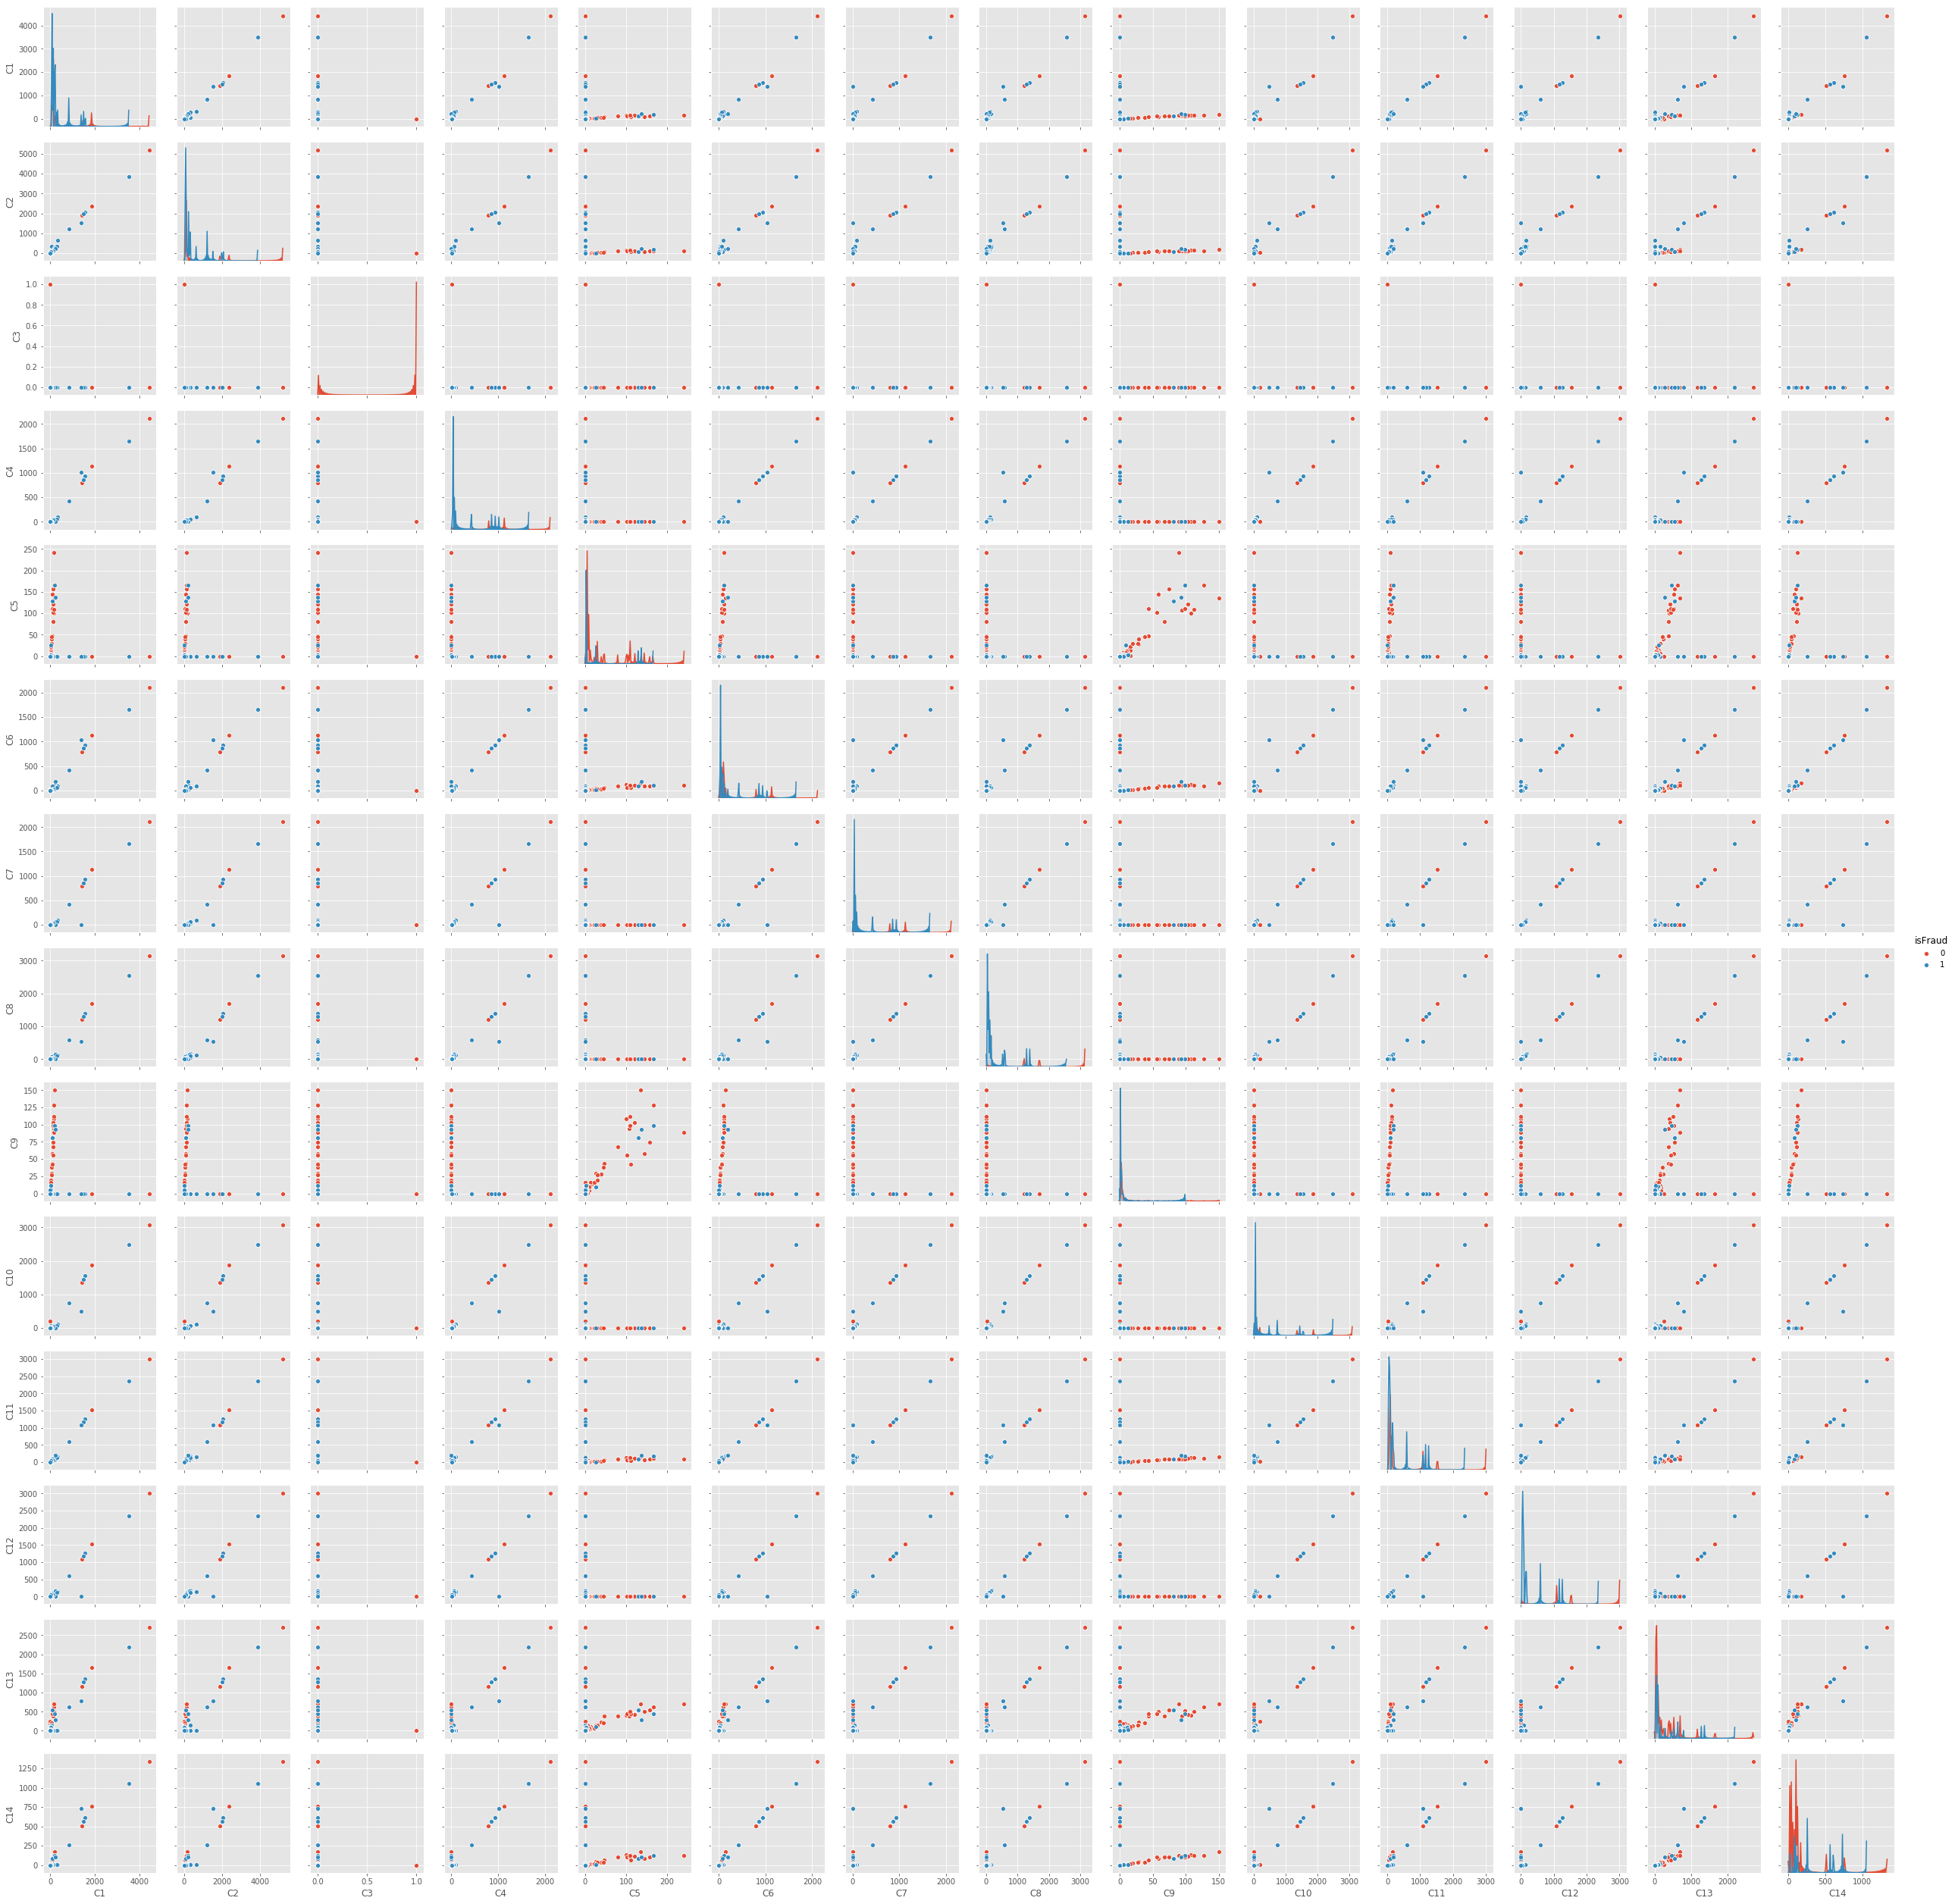

In [0]:
sampled_train = pd.concat([train_transaction.loc[train_transaction['isFraud'] == 0].sample(500),
          train_transaction.loc[train_transaction['isFraud'] == 1].sample(500)])

sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=c_cols)
plt.show()

サンプルを500個ずつ取ってきて，C1~C14のそれぞれでペアプロットしている．

### D1-D9

In [0]:
d_cols = [c for c in train_transaction if c[0] == 'D']
train_transaction[d_cols].head()

D1     D2    D3    D4   D5  D6  D7  D8  D9   D10    D11  D12  D13  D14  \
0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN   
1    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN   
2    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN   
3  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN  84.0    NaN  NaN  NaN  NaN   
4    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   NaN    NaN  NaN  NaN  NaN   

     D15  
0    0.0  
1    0.0  
2  315.0  
3  111.0  
4    NaN

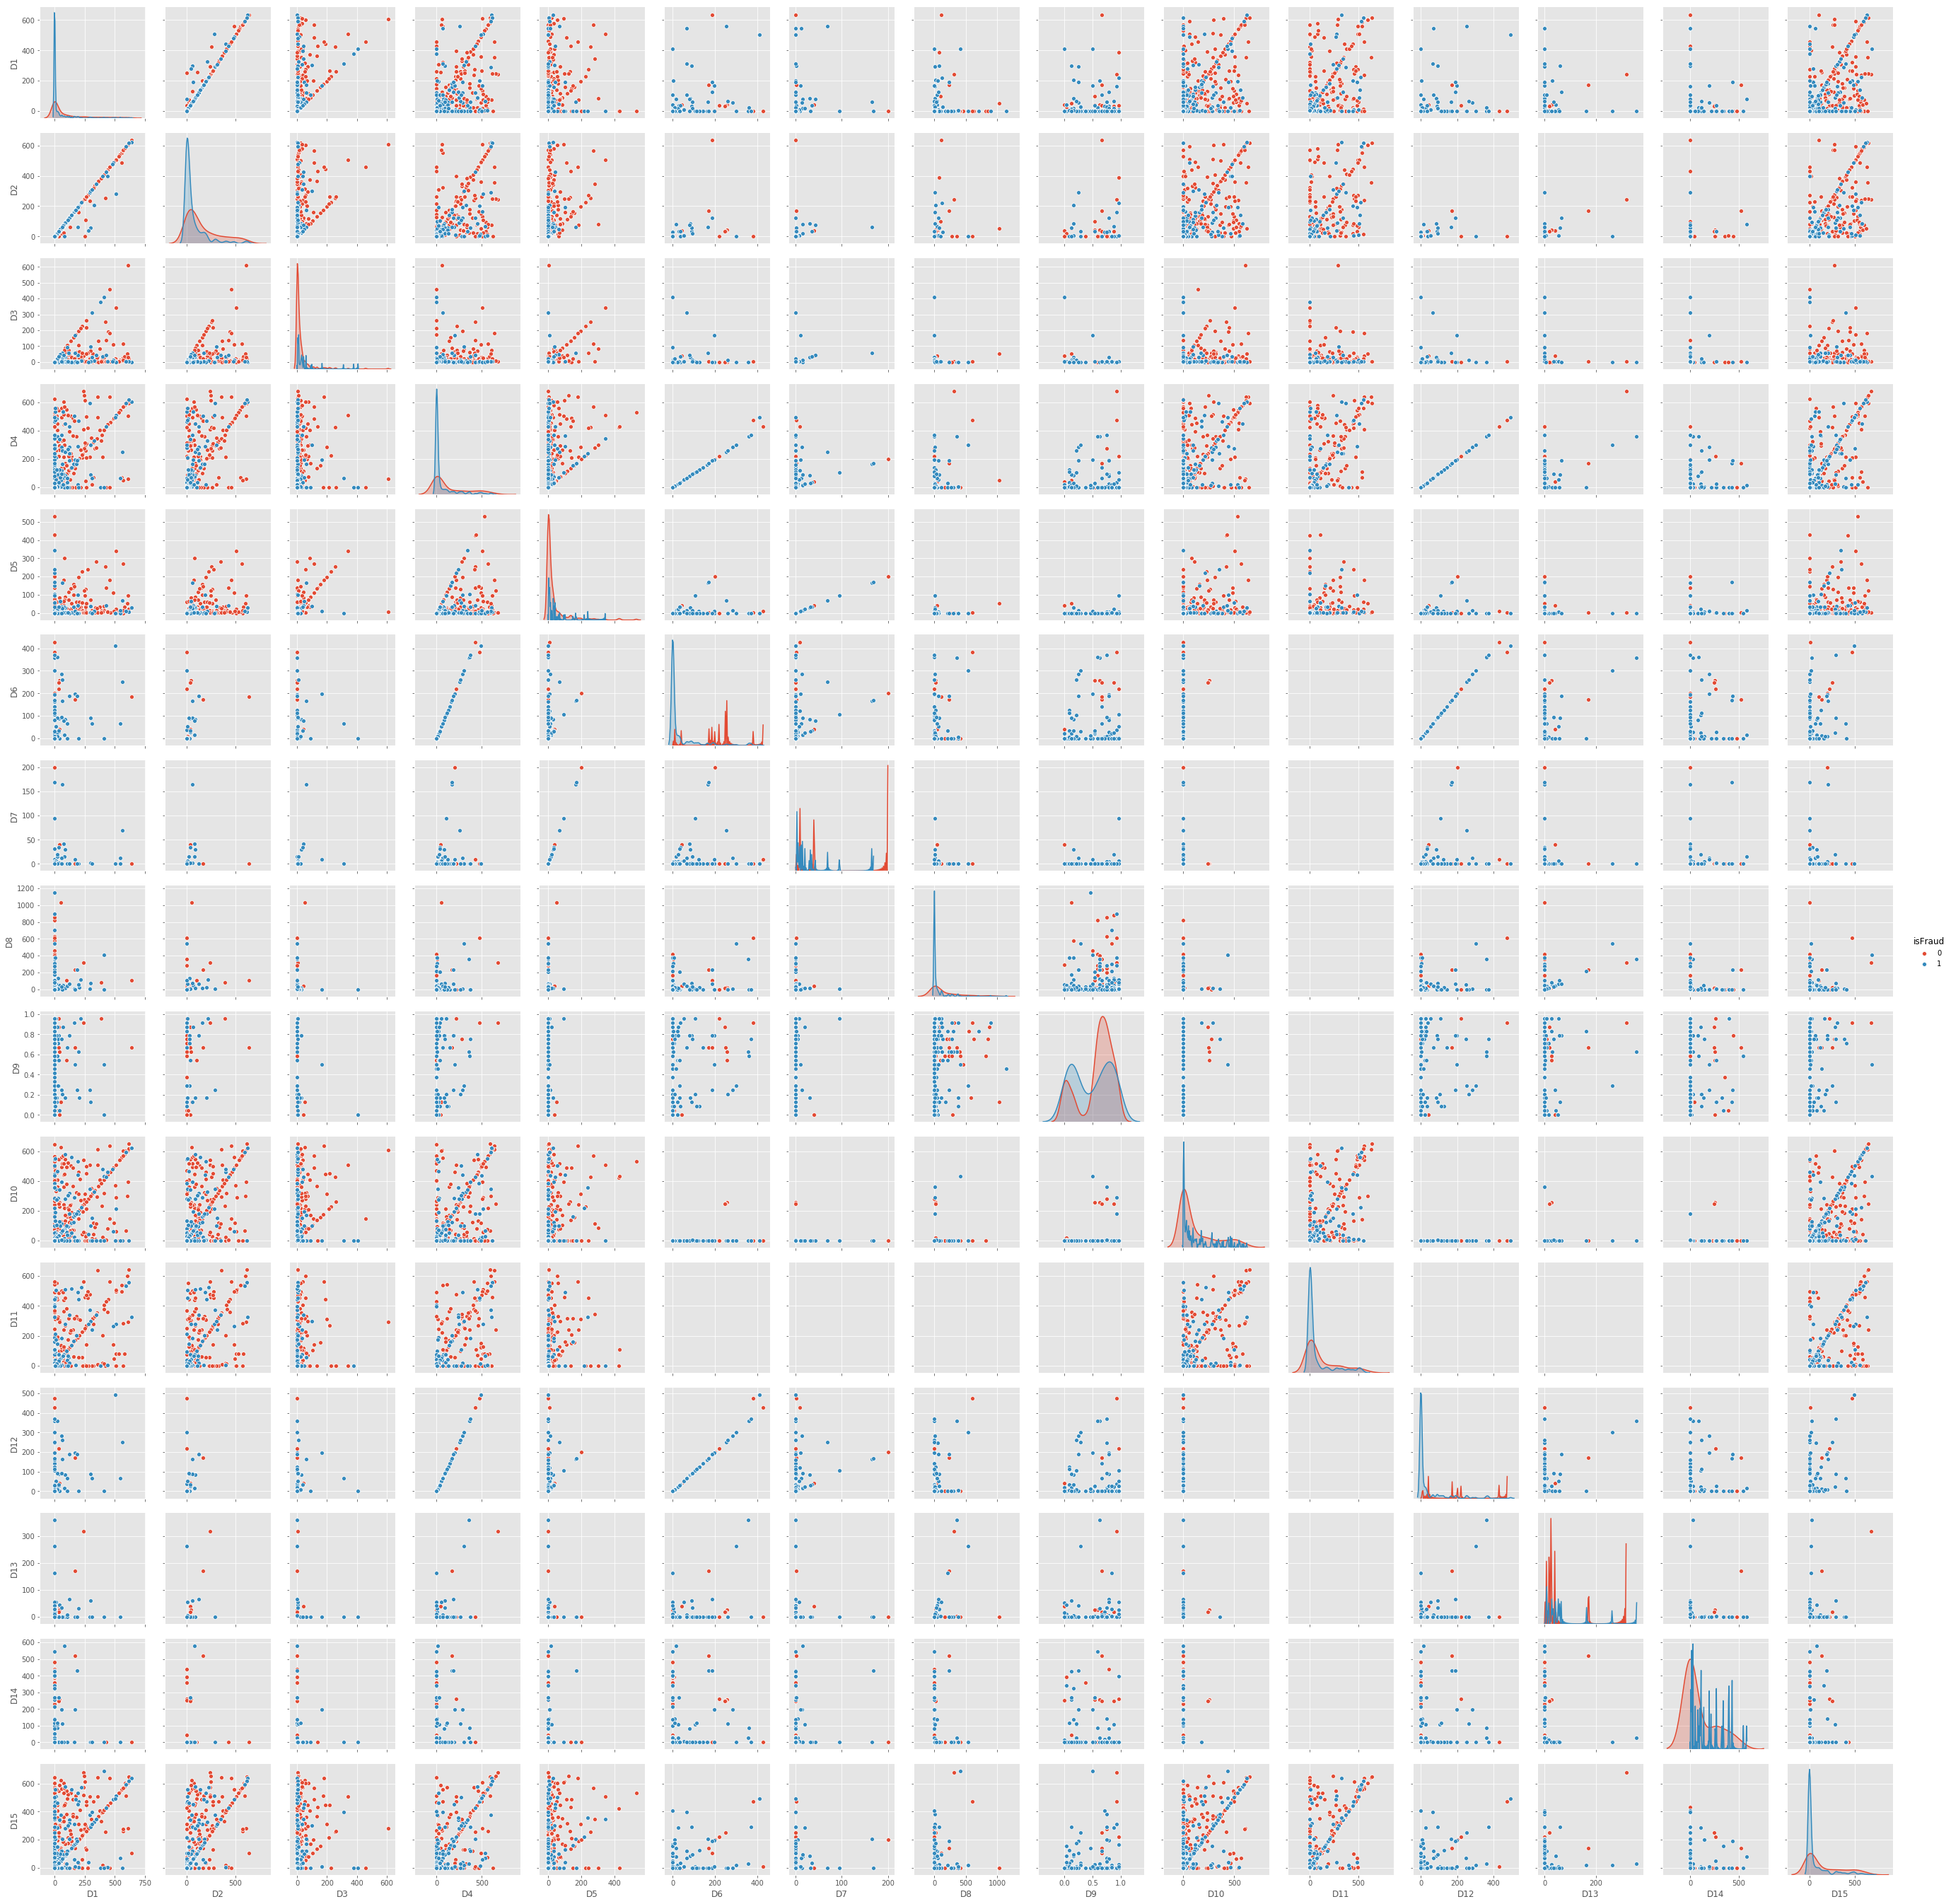

In [0]:
sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=d_cols)
plt.show()

### M1-M9

In [0]:
m_cols = [c for c in train_transaction if c[0] == 'M']
train_transaction[m_cols].head()

M1   M2   M3   M4   M5   M6   M7   M8   M9
0    T    T    T   M2    F    T  NaN  NaN  NaN
1  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN
2    T    T    T   M0    F    F    F    F    F
3  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

M4以外はTかFか欠損値．M4はM0~M2と欠損値．

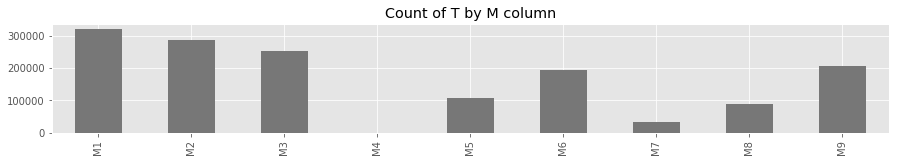

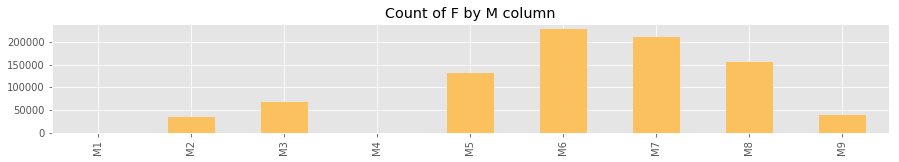

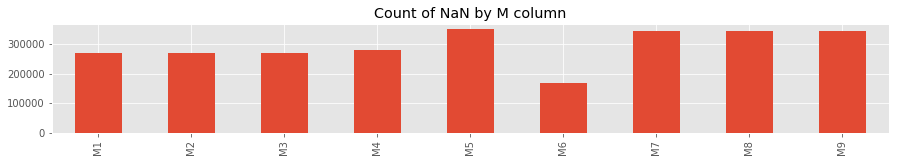

In [0]:
(train_transaction[m_cols] == 'T').sum().plot(kind='bar',
                                              title='Count of T by M column',
                                              figsize=(15, 2),
                                              color=color_pal[3])
plt.show()
(train_transaction[m_cols] == 'F').sum().plot(kind='bar',
                                              title='Count of F by M column',
                                              figsize=(15, 2),
                                              color=color_pal[4])
plt.show()
(train_transaction[m_cols].isna()).sum().plot(kind='bar',
                                              title='Count of NaN by M column',
                                              figsize=(15, 2),
                                              color=color_pal[0])
plt.show()

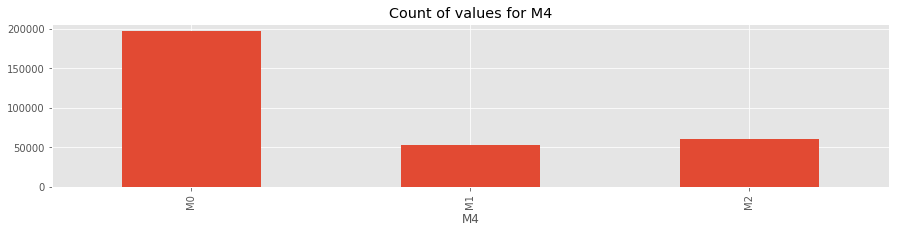

In [0]:
train_transaction.groupby('M4')['TransactionID'] \
    .count() \
    .plot(kind='bar',
          title='Count of values for M4',
          figsize=(15, 3))
plt.show()

### V1-V339

ほぼ1か0．欠損値多いクソデータ．

In [0]:
v_cols = [c for c in train_transaction if c[0] == 'V']
train_transaction[v_cols].head()

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  \
0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  \
0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  \
0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
3  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  \
0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
1  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
2  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
3  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V91  V92  V93  V94  V95   V96   V97  V98   V99  V100  V101  V102  V103  \
0  0.0  0.0  0.0  0.0  0.0   1.0   0.0  0.0   0.0   0.0   0.0   1.0   0.0   
1  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   
3  0.0  0.0  0.0  0.0  1.0  48.0  28.0  0.0  10.0   4.0   1.0  38.0  24.0   
4  NaN  NaN  NaN  NaN  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   

   V104  V105  V106  V107  V108  V109  V110  V111  V112  V113  V114  V115  \
0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
4   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

   V116  V117  V118  V119  V120  V121  V122  V123  V124  V125  V126    V127  \
0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   117.0   
1   1.0   1.0   1.0   1.0   1.0   

In [0]:
train_transaction[v_cols].describe()

V1             V2             V3             V4  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.999945       1.045204       1.078075       0.846456   
std         0.007390       0.240133       0.320890       0.440053   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         1.000000       8.000000       9.000000       6.000000   

                  V5             V6             V7             V8  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.876991       1.045686       1.072870       1.027704   
std         0.475902       0.239385       0.304779       0.186069   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         6.000000       9.000000       9.000000       8.000000   

                  V9            V10            V11            V12  \
count  311253.000000  311253.000000  311253.000000  514467.000000   
mean        1.041529       0.463915       0.478987       0.559711   
std         0.226339       0.521522       0.552431       0.510533   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       0.000000       0.000000   
50%         1.000000       0.000000       0.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         8.000000       4.000000       5.000000       3.000000   

                 V13            V14            V15            V16  \
count  514467.000000  514467.000000  514467.000000  514467.000000   
mean        0.599166       0.999500       0.122342       0.123460   
std         0.532185       0.022345       0.332422       0.342841   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         1.000000       1.000000       0.000000       0.000000   
max         6.000000       1.000000       7.000000      15.000000   

                 V17            V18            V19            V20  \
count  514467.000000  514467.000000  514467.000000  514467.000000   
mean        0.134040       0.135363       0.816371       0.847843   
std         0.364456       0.371763       0.425512       0.459451   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       1.000000   
50%         0.000000       0.000000       1.000000       1.000000   
75%         0.000000       0.000000       1.000000       1.000000   
max        15.000000      15.000000       7.000000      15.000000   

                 V21            V22            V23            V24  \
count  514467.000000  514467.000000  514467.000000  514467.000000   
mean        0.129684       0.132292       1.034791       1.058097   
std         0.339060       0.359415       0.247681       0.305485   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       1.000000   
50%         0.000000       0.000000       1.000000       1.000000   
75%         0.000000       0.000000       1.000000       1.000000   
max         5.000000       8.000000      13.000000      13.000000   

                 V25            V26            V27            V28  \
count  514467.000000  514467.000000  514467.000000  514467.000000   
mean        0.977660       0.988040       0.000776       0.000830   
std         0.185245       0.209302       0.028596       0.031133   
min       

In [0]:
train_transaction['v_mean'] = train_transaction[v_cols].mean(axis=1)

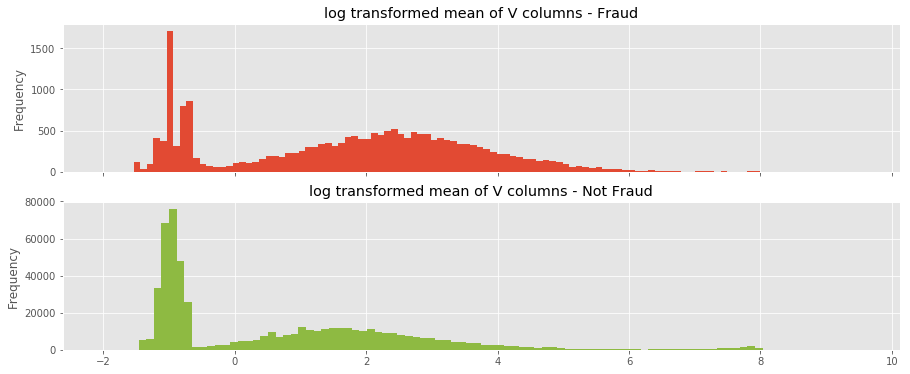

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
train_transaction.loc[train_transaction['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
train_transaction.loc[train_transaction['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          color=color_pal[5],
          ax=ax2)
plt.show()


V全部の値を雑に平均して，同じく対数処理してグラフ化したやつ．ぱっと見Vの値が大きい方がFraudである可能性は高そう．

## Identity Data

Transaction とTransactionIDで紐づけられているが，全部が紐づけられている訳ではない．顧客自身のデータが載っている．

In [0]:
#  `isFraud` カラムを解析のために加える．
train_identity_ = train_identity.merge(train_transaction[['TransactionID',
                                                         'TransactionDT',
                                                         'isFraud']],
                                      on=['TransactionID'])

test_identity_ = test_identity.merge(test_transaction[['TransactionID',
                                                      'TransactionDT']],
                                    on=['TransactionID'])

### Device Type

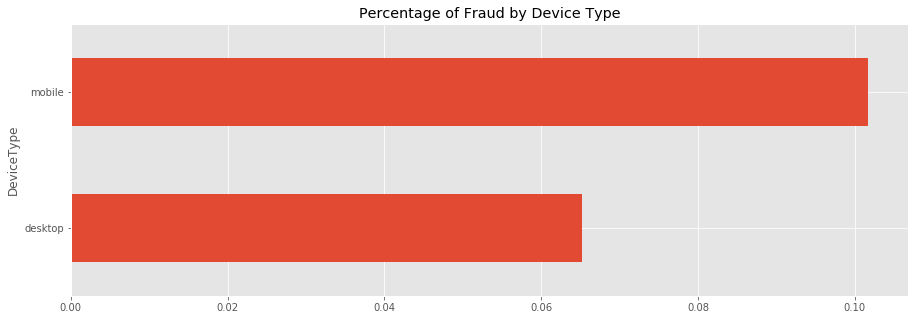

In [0]:
train_identity_.groupby('DeviceType') \
    .mean()['isFraud'] \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Percentage of Fraud by Device Type')
plt.show()

mobileの方がFraudの確率が高い

### Device Info

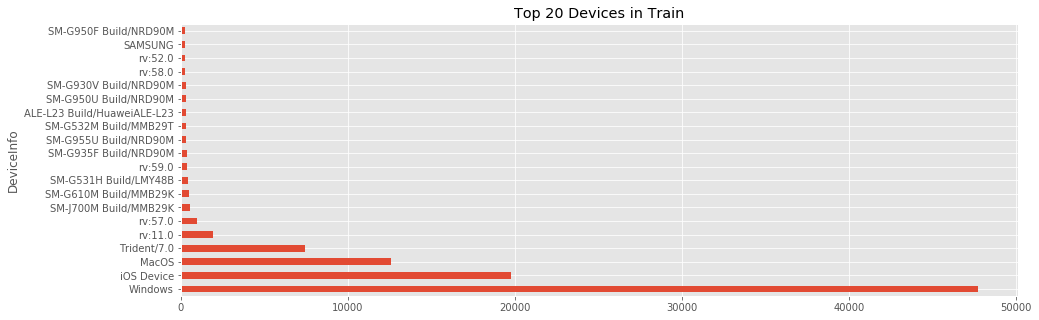

In [0]:
train_identity_.groupby('DeviceInfo') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 5), title='Top 20 Devices in Train')
plt.show()


### 以下idの分析

### Identity info as a function of time

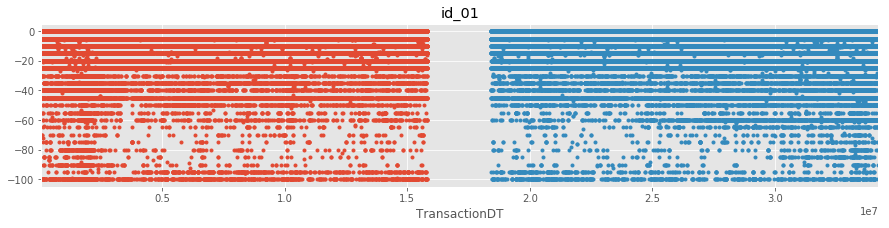

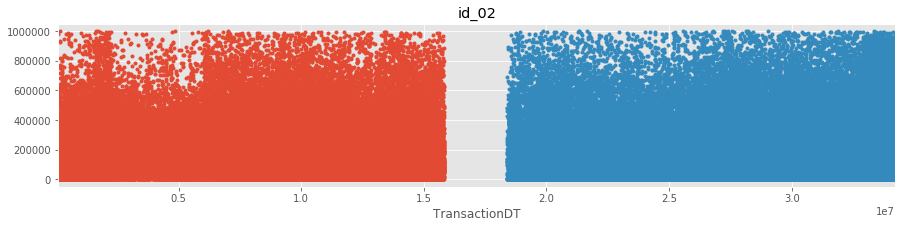

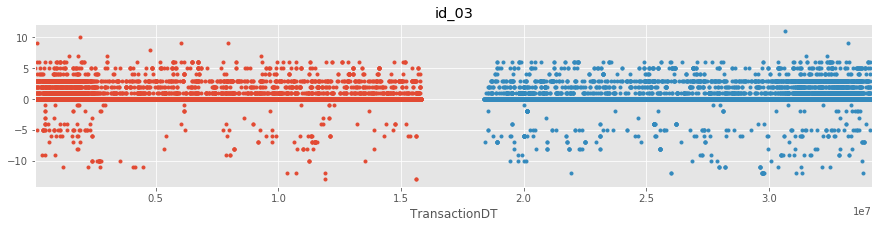

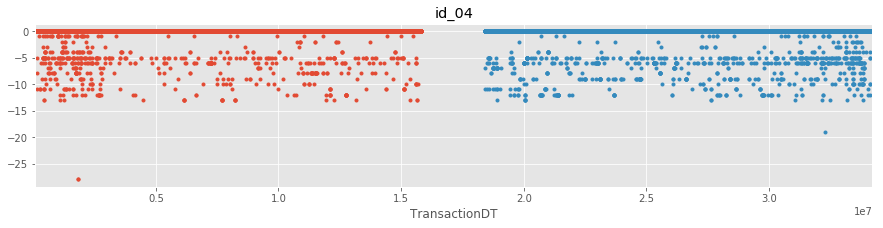

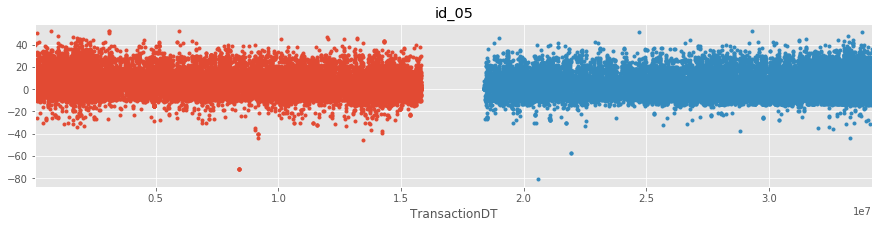

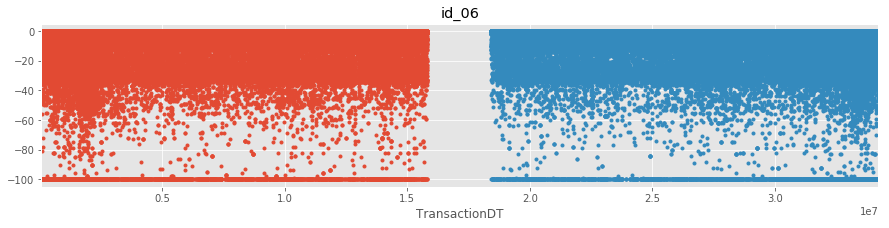

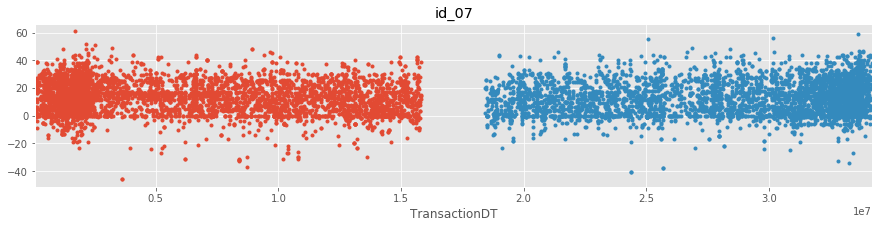

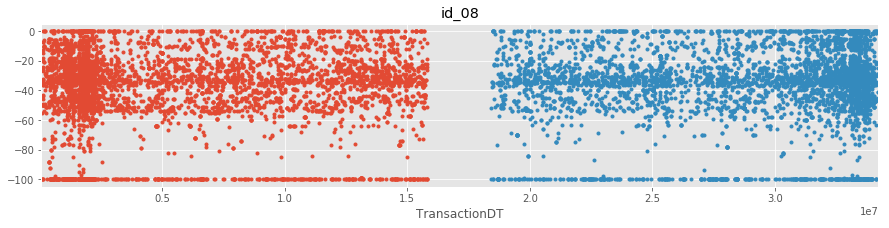

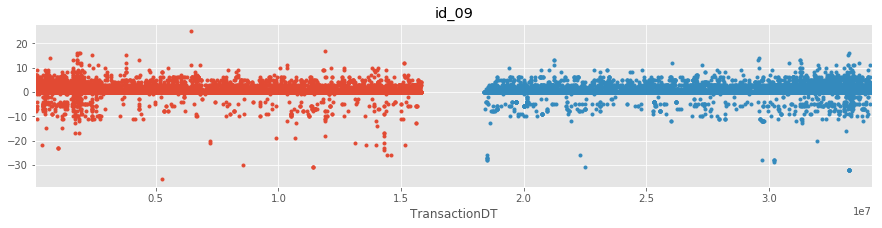

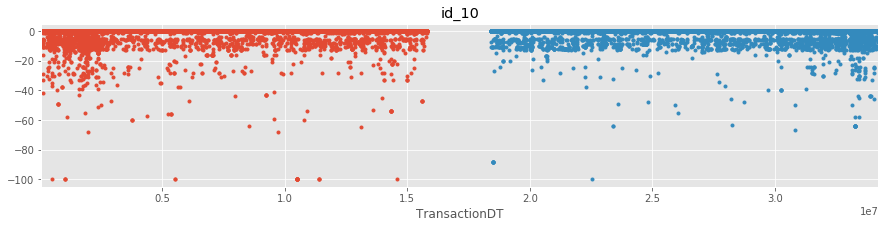

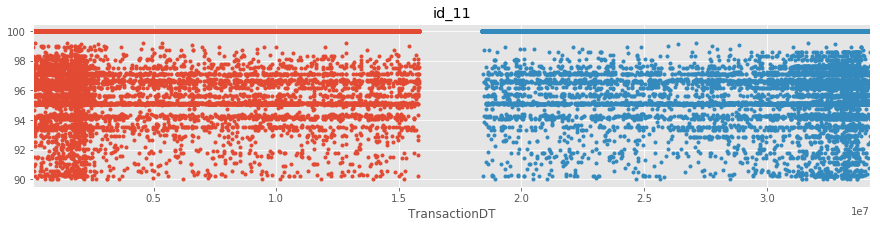

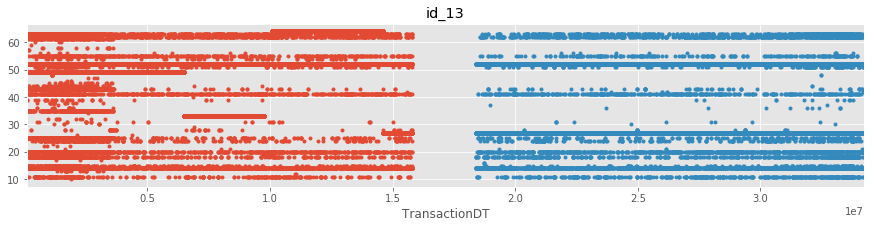

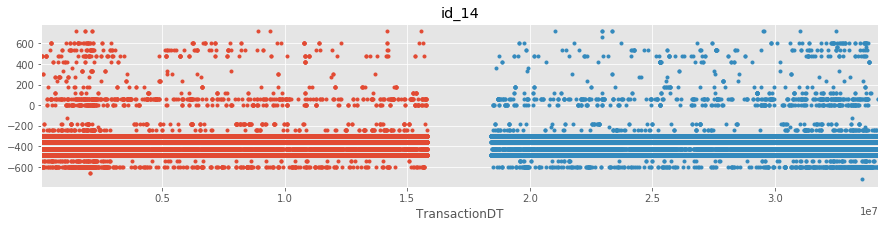

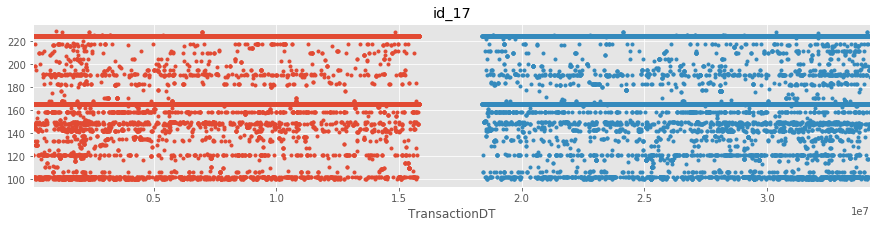

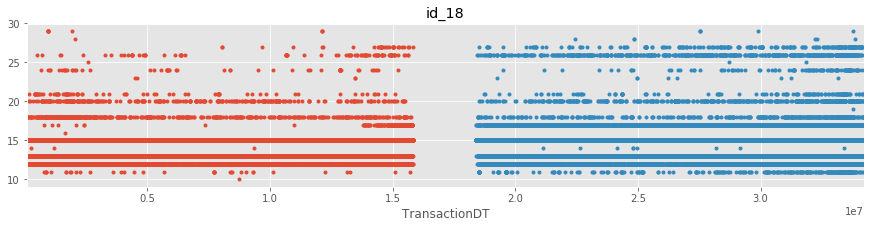

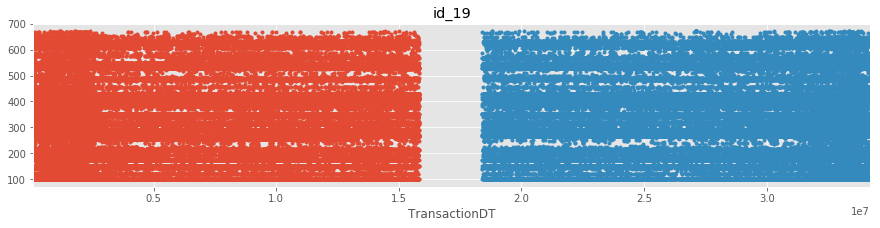

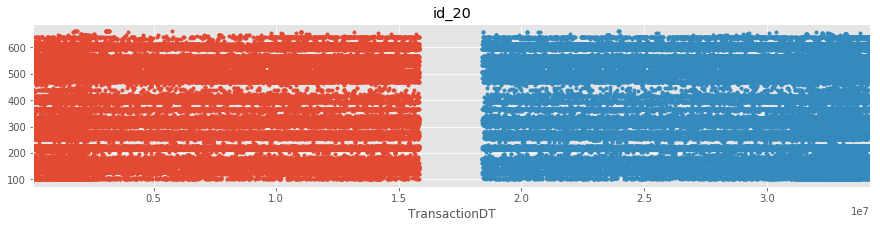

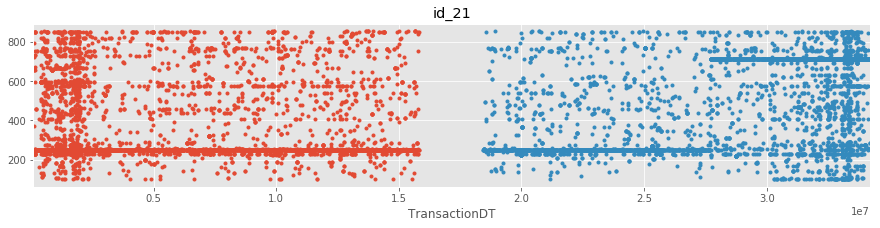

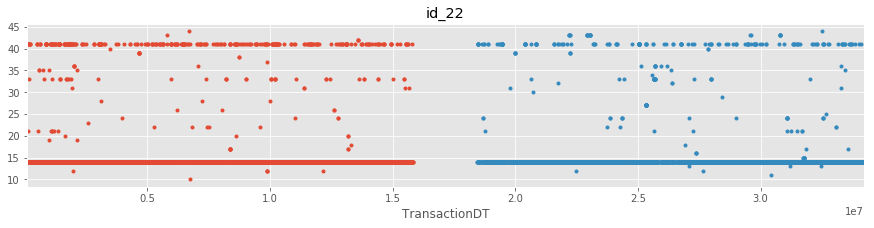

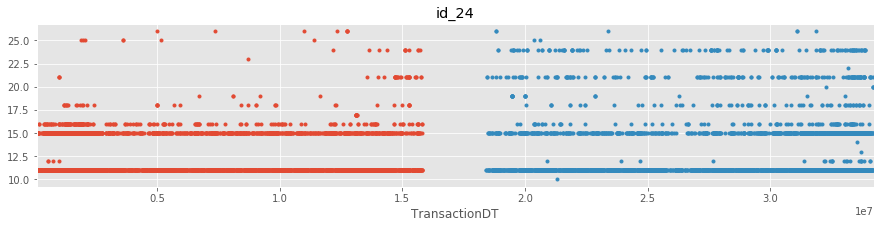

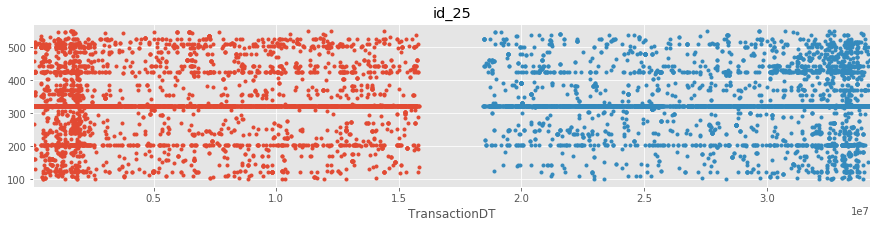

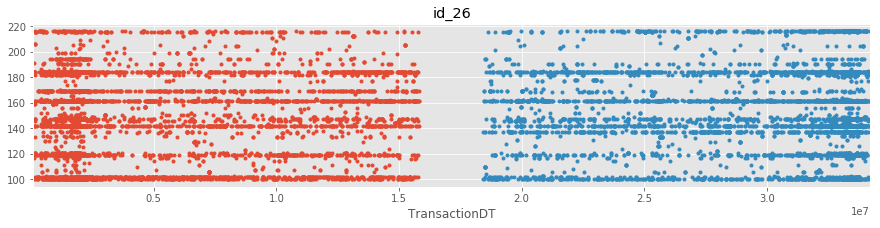

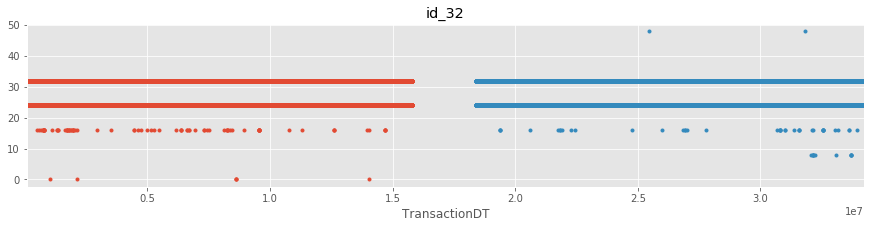

In [0]:
id_cols = [c for c in train_identity.columns if 'id' in c]
for i in id_cols:
    try:
        train_identity_.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        test_identity_.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        plt.show()
    except TypeError:
        pass

In [6]:
train_id_trn = pd.merge(train_identity, train_transaction[['isFraud','TransactionID']])
train_id_f0 = train_id_trn[train_id_trn['isFraud'] == 0]
train_id_f1 = train_id_trn[train_id_trn['isFraud'] == 1]
del train_id_trn
print(train_id_f0.shape, train_id_f1.shape)

def plotHistByFraud(col, bins=20, figsize=(8,3)):
    with np.errstate(invalid='ignore'):
        plt.figure(figsize=figsize)
        plt.hist([train_id_f0[col], train_id_f1[col]], bins=bins, density=True, color=['royalblue', 'orange'])
        
def plotCategoryRateBar(col, topN=np.nan, figsize=(8,3)):
    a, b = train_id_f0, train_id_f1
    if topN == topN: # isNotNan
        vals = b[col].value_counts(normalize=True).to_frame().iloc[:topN,0]
        subA = a.loc[a[col].isin(vals.index.values), col]
        df = pd.DataFrame({'normal':subA.value_counts(normalize=True), 'fraud':vals})
    else:
        df = pd.DataFrame({'normal':a[col].value_counts(normalize=True), 'fraud':b[col].value_counts(normalize=True)})
    df.sort_values('fraud', ascending=False).plot.bar(figsize=figsize)

(132915, 42) (11318, 42)


### id_01~id_11

青がNon_fraudでオレンジがFraud

id_01

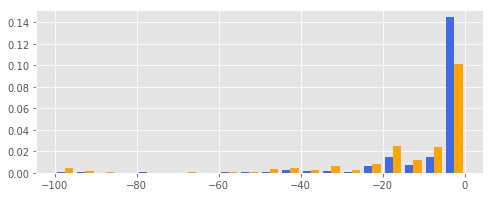

In [0]:
plotHistByFraud('id_01')

id_02

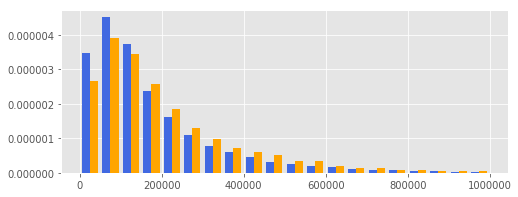

In [0]:
plotHistByFraud('id_02')

id_07

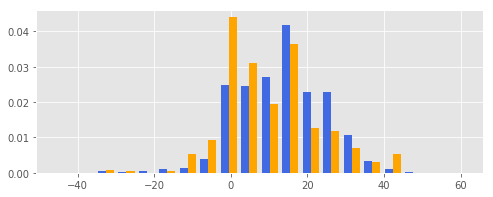

In [0]:
plotHistByFraud('id_07')

id_01~id_12の，Fraud率の違い．

In [0]:
numid_cols = [f'id_{str(i).zfill(2)}' for i in range(1,12)]
train_id_f1[['isFraud'] + numid_cols].head(10)

isFraud  id_01     id_02  id_03  ...  id_08  id_09  id_10       id_11
52         1    0.0  169947.0    0.0  ...    NaN    0.0    0.0  100.000000
53         1    0.0  222455.0    0.0  ...    NaN    0.0    0.0  100.000000
54         1    0.0  271870.0    0.0  ...    NaN    0.0    0.0  100.000000
69         1  -20.0  258138.0    NaN  ...    NaN    NaN    NaN  100.000000
86         1   -5.0  141271.0    NaN  ...    NaN    0.0    0.0   97.540001
98         1  -20.0  550210.0    NaN  ...    NaN    NaN    NaN  100.000000
185        1  -25.0   59967.0    NaN  ...    NaN    NaN    NaN  100.000000
201        1   -5.0   30602.0    NaN  ...    NaN    0.0    0.0   95.080002
235        1   -5.0    4235.0    NaN  ...    NaN    NaN    NaN  100.000000
236        1    0.0   36004.0    0.0  ...    NaN    0.0    0.0  100.000000

[10 rows x 12 columns]

In [0]:
train_id_f0[['isFraud'] + numid_cols].head(10)

isFraud  id_01     id_02  id_03  id_04  ...  id_07  id_08  id_09  id_10  id_11
0        0    0.0   70787.0    NaN    NaN  ...    NaN    NaN    NaN    NaN  100.0
1        0   -5.0   98945.0    NaN    NaN  ...    NaN    NaN    NaN    NaN  100.0
2        0   -5.0  191631.0    0.0    0.0  ...    NaN    NaN    0.0    0.0  100.0
3        0   -5.0  221832.0    NaN    NaN  ...    NaN    NaN    NaN    NaN  100.0
4        0    0.0    7460.0    0.0    0.0  ...    NaN    NaN    0.0    0.0  100.0
5        0   -5.0   61141.0    3.0    0.0  ...    NaN    NaN    3.0    0.0  100.0
6        0  -15.0       NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
7        0    0.0   31964.0    0.0    0.0  ...    NaN    NaN    0.0    0.0  100.0
8        0  -10.0  116098.0    0.0    0.0  ...    NaN    NaN    0.0    0.0  100.0
9        0   -5.0  257037.0    NaN    NaN  ...    NaN    NaN    NaN    NaN  100.0

[10 rows x 12 columns]

### id_12-id_38

id_15

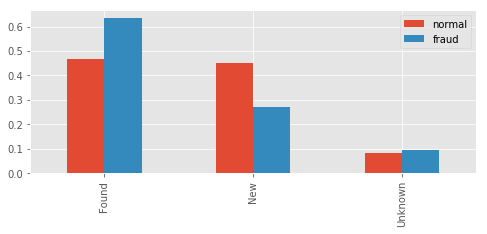

In [7]:
plotCategoryRateBar('id_15')

id_16

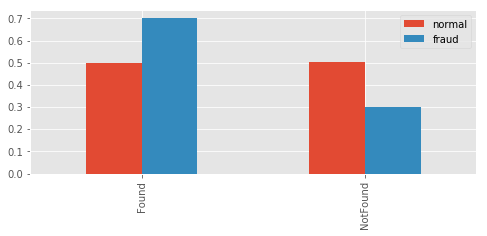

In [8]:
plotCategoryRateBar('id_16')

id_17

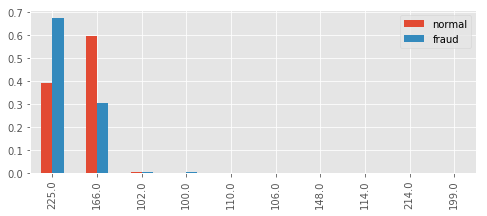

In [9]:
plotCategoryRateBar('id_17', 10)

id_19

unique count: 522


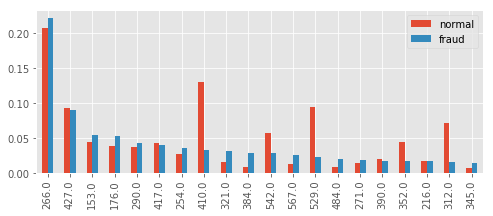

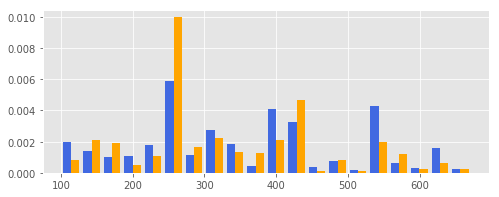

In [11]:
plotCategoryRateBar('id_19', 20)
plotHistByFraud('id_19')
print('unique count:', train_identity['id_19'].nunique())

id_20

unique count: 394


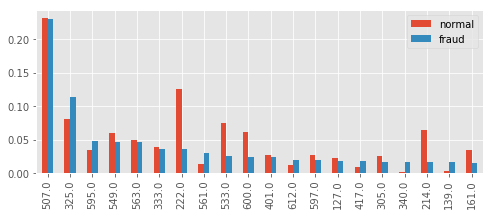

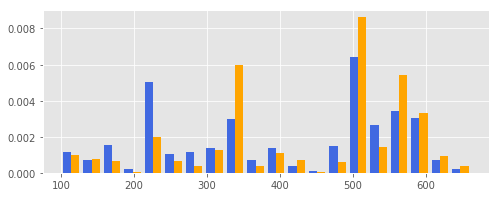

In [13]:
plotCategoryRateBar('id_20', 20)
plotHistByFraud('id_20')
print('unique count:', train_identity['id_20'].nunique())

id_23

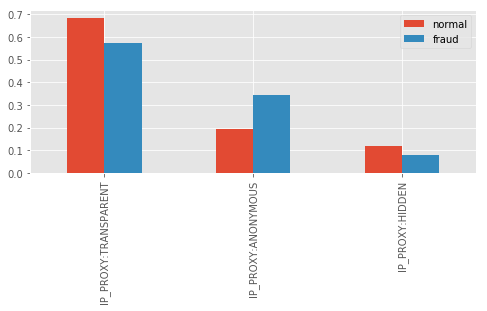

In [14]:
plotCategoryRateBar('id_23')

id_26

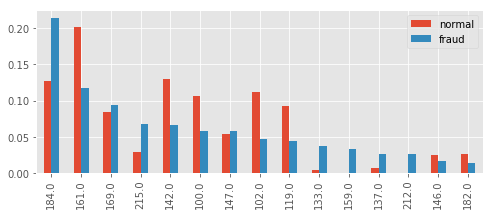

In [15]:
plotCategoryRateBar('id_26', 15)

id_28

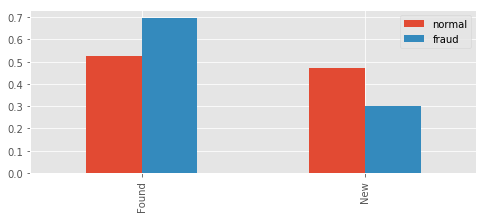

In [16]:
plotCategoryRateBar('id_28')

id_29

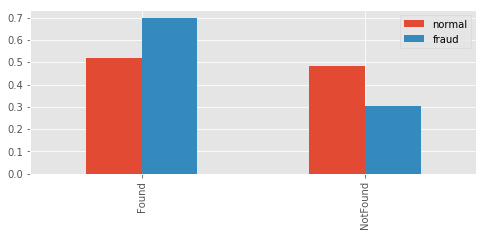

In [17]:
plotCategoryRateBar('id_29')

id_31

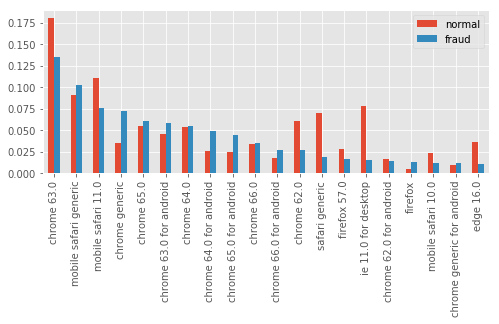

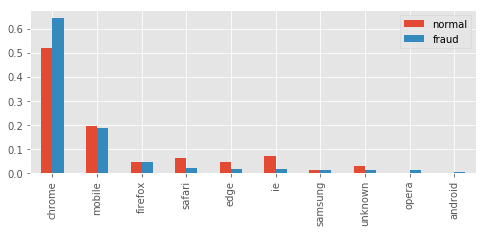

In [18]:
plotCategoryRateBar('id_31', 20)

train_id_f0['_id_31_ua'] = train_id_f0['id_31'].apply(lambda x: x.split()[0] if x == x else 'unknown')
train_id_f1['_id_31_ua'] = train_id_f1['id_31'].apply(lambda x: x.split()[0] if x == x else 'unknown')
plotCategoryRateBar('_id_31_ua', 10)

id_32

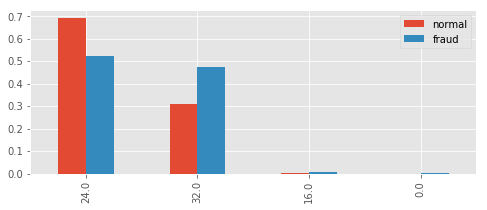

In [19]:
plotCategoryRateBar('id_32')

id_33

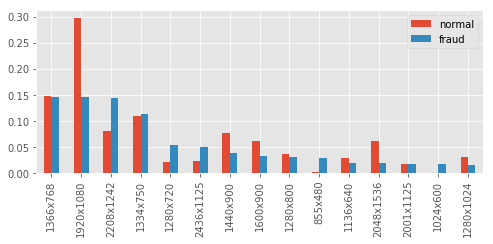

In [20]:
plotCategoryRateBar('id_33', 15)

id_34

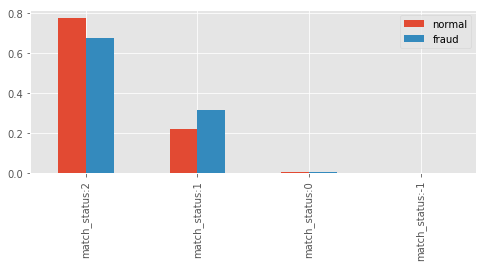

In [21]:
plotCategoryRateBar('id_34')

id_35

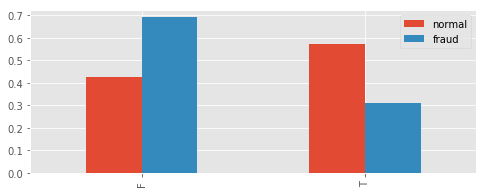

In [22]:
plotCategoryRateBar('id_35')

id_38

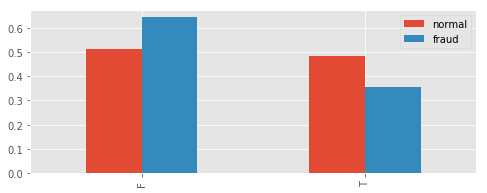

In [23]:
plotCategoryRateBar('id_38')

## 面白いカラムシリーズ

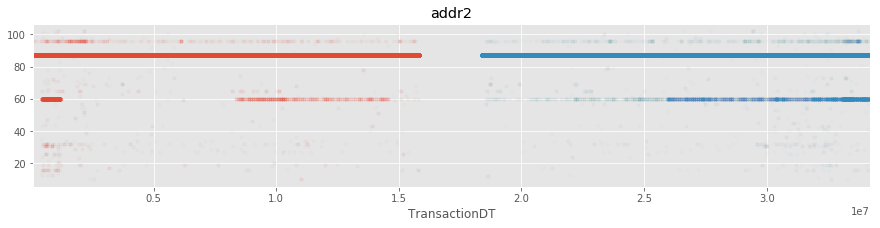

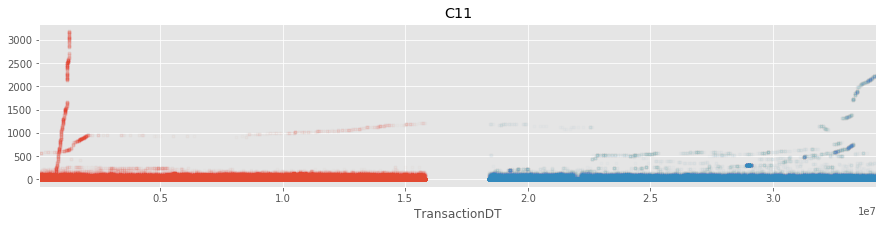

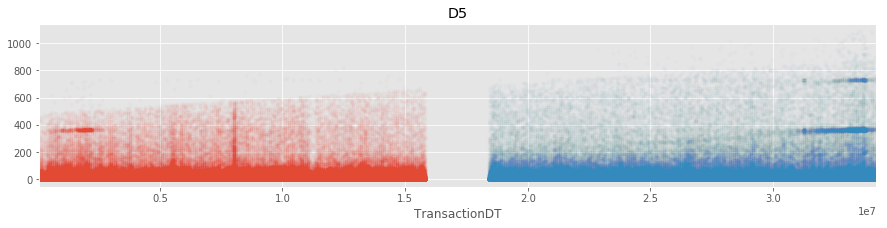

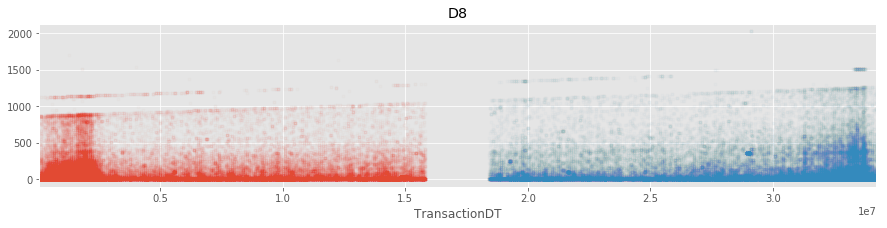

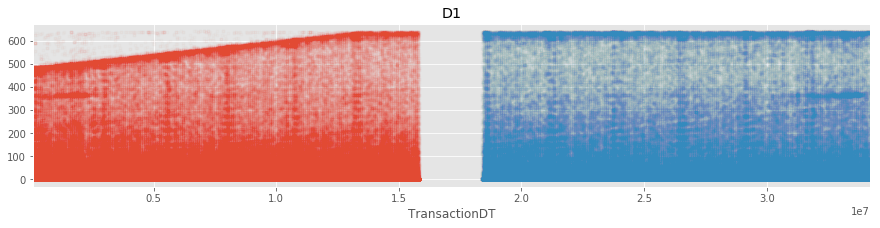

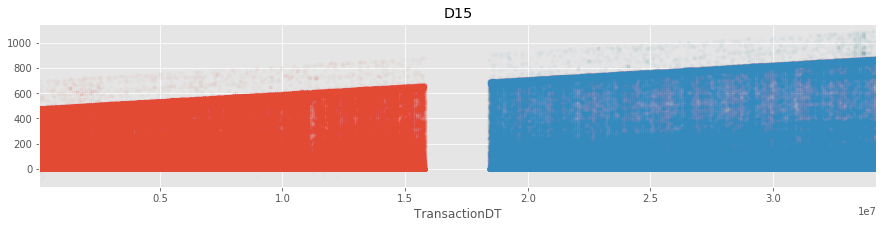

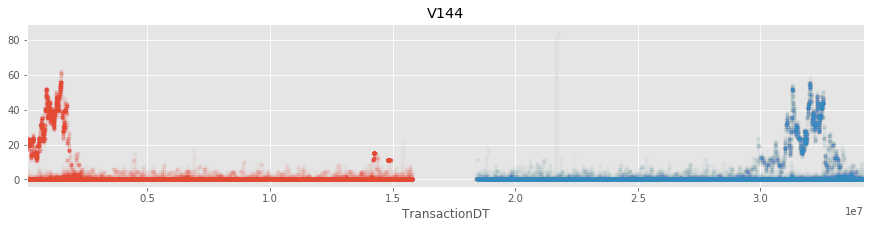

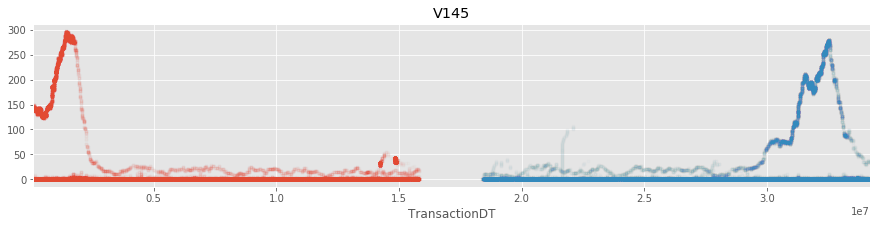

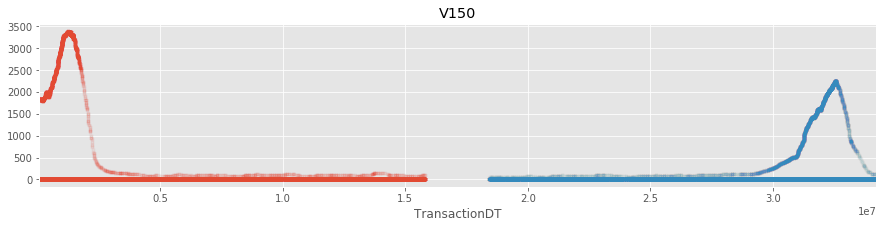

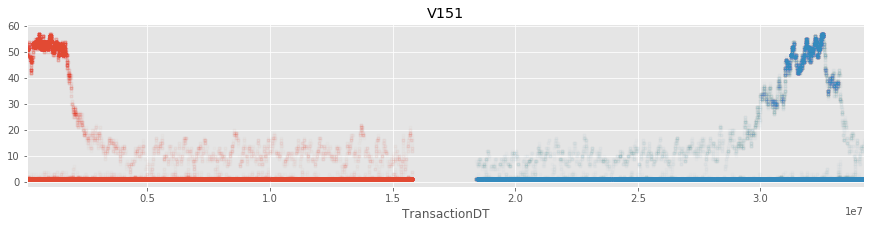

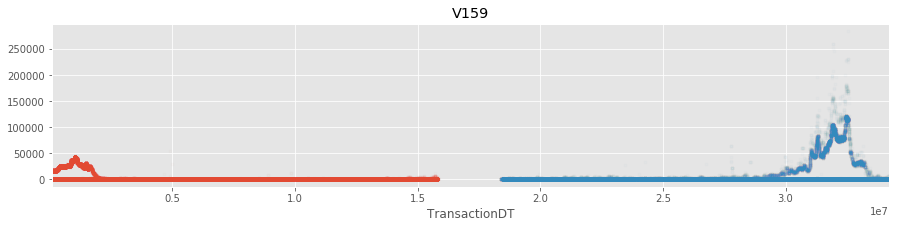

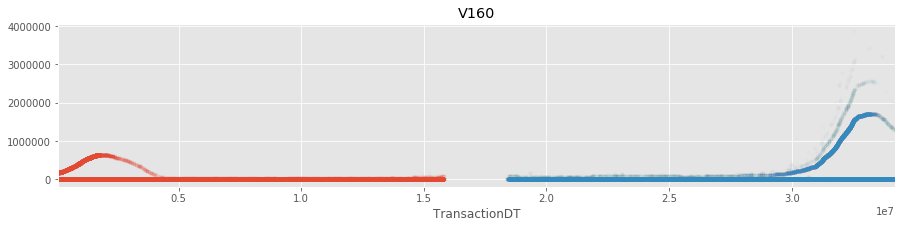

In [0]:
for c in ['addr2','C11','D5','D8','D1','D15','V144','V145','V150','V151','V159','V160']:
    try:
        train_transaction.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        test_transaction.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        plt.show()
    except TypeError:
        pass
    except KeyError:
        pass

id_01-id_11は連続値．id_12-id_38はカテゴリー

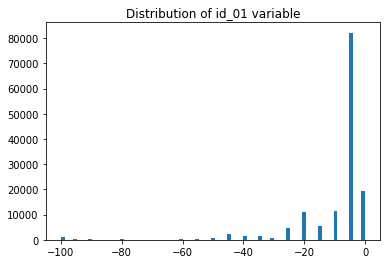

In [0]:
plt.hist(train['id_01'], bins=77);
plt.title('Distribution of id_01 variable');

id_01は77の負の値のみ存在．

In [0]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64

88%が欠損値，10%が０．つまり98%が欠損かゼロ．

In [0]:
train['id_11'].value_counts(dropna=False, normalize=True).head()

NaN           0.761273
100.000000    0.225492
95.080002     0.002085
95.160004     0.001277
97.120003     0.000745
Name: id_11, dtype: float64

76%が欠損値．22%が100．
キモいデータ

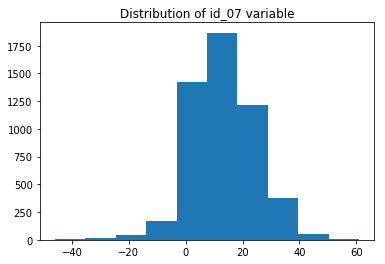

In [0]:
plt.hist(train['id_07']);
plt.title('Distribution of id_07 variable');